In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage,AnnotationBbox
from matplotlib.font_manager import fontManager, FontProperties
import ptitprince as pt
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import pingouin as pg
import statsmodels.api as sm
import language_tool_python as ltp


def get_img(name):
     path = "font/emojis/{}.png".format(name)
     im = plt.imread(path)
     return im

def offset_image(coord, name, ax, size=0.5):
    img = get_img(name)
    im = OffsetImage(img, zoom=size)
    im.image.axes = ax
    ab = AnnotationBbox(im, (coord, 0),  xybox=(0., -21.), frameon=False,
                        xycoords='data',  boxcoords="offset points", pad=0)
    ax.add_artist(ab)

def raincloud(x, y, markersize, df, order=None, hue=None):
    # adding color
    pal = sns.color_palette()
    if df is not None:
        means = df.groupby([x])[y].mean().reindex(order)
    else:
        if len(order) > 2:
            raise Exception('Too many unique x values for this custom plot')

        mean_1 = np.mean([i[0] for i in zip(y, x) if i[1] == order[0]])
        mean_2 = np.mean([i[0] for i in zip(y, x) if i[1] == order[1]])
        means = [mean_1, mean_2]

    dodge = None
    if hue:
        means = df.groupby([x, hue])[y].mean().reindex(order)
        dodge = True
        
    sns.scatterplot(x=means.index, y=means, color='white', edgecolor='black', s=150/2, linewidth=1.5, zorder=4)
    ax = pt.half_violinplot(x=x, y=y, data=df, palette=pal, bw=.25, cut=0., linewidth=0, 
                            scale="area", width=.7, inner=None, orient='v', zorder=1, order=order, hue=hue, dodge=dodge)
    ax = sns.stripplot(x=x, y=y, data=df, palette=pal, edgecolor="white",  linewidth=1, order=order,
                       size=markersize, orient='v', zorder=2, jitter=1, alpha=0.6, hue=hue, dodge=dodge)
    ax2 = sns.pointplot(x=x, y=y, data=df, color='black',  join=False, errorbar='se', linewidth=1,
     edgecolor='black', capsize=.06, zorder=3, bw=0, order=order, hue=hue, dodge=dodge)

/media/getz/ae930ef3-4ac4-4a95-a76a-47e9ab0a2b27/Python/CognitiveReflection/venv/lib/python3.8/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [101]:
f1 = 'HUMANS/turing_dv3_82.csv'
f2 = 'HUMANS/turing_109.csv'
f3 = 'HUMANS/turing_prolific_65.csv'
df1 = pd.read_csv(f1)
df2 = pd.read_csv(f2)
df3 = pd.read_csv(f3)

for df, n_rows, engine in zip([df1, df2, df3], [135, 138, 138], ['dv3', 'dv2', 'dv2_prolific']):
    df = df[df.prolific_id.isin(df.prolific_id.value_counts()[
                                df.prolific_id.value_counts() == n_rows].index)]

    print("complete =", (df.groupby('prolific_id').prolific_id.count() == n_rows).sum())
    print("incomplete =", (df.groupby(
        'prolific_id').prolific_id.count() != n_rows).sum())
    # print("dataset_id that are complete =", df.dataset_id.value_counts()==138)
    print("dataset_id that are incomplete =",
          [
              i for i in range(77)
              if i not in df.dataset_id.value_counts().index
          ])
    print("dataset_id that are complete =",
          [
              i for i in range(77)
              if i in df.dataset_id.value_counts().index
          ])

    print("dataset_id that are incomplete =",
          len(
              [i for i in range(77) if i not in df.dataset_id.value_counts().index]))

    df['correct'] = None
    df['correct'] = df.correct.astype(bool)
    df['agree1'] = None
    df['agree1'] = df.agree1.astype(bool)
    df['agree2'] = None
    df['agree2'] = df.agree2.astype(bool)

    df.loc[df.q_id == 2, 'correct'] = df.source == df.answer
    
    if engine == 'dv2_prolific':
        df.loc[df.q_id == 2, 'correct'] = \
            ((df.source == 'Human') & (df.answer == 'Prolific')) | ((df.source == 'AI') & (df.answer == 'Not Prolific'))
    df.loc[df.q_id == 1, 'agree2'] = df.answer.str.contains('Yes')
    df.loc[df.q_id == 0, 'agree1'] = df.answer.str.contains('Yes')

    # clear weird characters in answers
    df.loc[df.answer.str.contains('Yes'), 'answer'] = 'Yes'
    # df.loc[df.answer.str.contains('No'), 'answer'] = 'No'
    df.loc[df.answer.str.contains('AI'), 'answer'] = 'AI'
    df.loc[df.answer.str.contains('Human'), 'answer'] = 'Human'

    # add correct and agree1 to all rows where item id is the same (easier to plot)
    for i in df.item_id.unique():
        df.loc[df.item_id == i, 'correct'] = \
            df[(df.item_id == i) & (df.q_id == 2)].correct.values[0]
        df.loc[df.item_id == i, 'agree1'] = \
            df[(df.item_id == i) & (df.q_id == 0)].agree1.values[0]
        df.loc[df.item_id == i, 'agree2'] = \
            df[(df.item_id == i) & (df.q_id == 1)].agree2.values[0]

        df.loc[df.item_id == i, 'turing'] = \
            df[(df.item_id == i) & (df.q_id == 2)].answer.values[0]

    # df['agree1']
    df['agree_both'] = df.agree1 & df.agree2
    df['disagree_both'] = ~df.agree1 & ~df.agree2
    
    df['engine'] = engine
    
    exec(f'{engine} = df.copy()')

np.random.seed(123)
# TODO: keep only one subject per dataset id
ids_to_keep_dv2 = []
ids_to_keep_dv3 = []
for i in range(77):
    ids_to_keep_dv2.append(
        np.random.choice(dv2[dv2.dataset_id == i].prolific_id.unique()))
    try:
        ids_to_keep_dv3.append(
            np.random.choice(dv3[dv3.dataset_id == i].prolific_id.unique()))
    except:
        print('Index error', i)
dv2 = dv2[dv2.prolific_id.isin(ids_to_keep_dv2)]
dv3 = dv3[dv3.prolific_id.isin(ids_to_keep_dv3)]
# dv2_prolific = dv2_prolific[dv2_prolific.prolific_id.isin(ids_to_keep)]
# ids = dv2.groupby('dataset_id').prolific_id.transform('nunique') > 1
# print(ids)
df = pd.concat([dv2, dv3, dv2_prolific])


complete = 82
incomplete = 0
dataset_id that are incomplete = [76]
dataset_id that are complete = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75]
dataset_id that are incomplete = 1


/tmp/ipykernel_236364/2369826809.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['correct'] = None
/tmp/ipykernel_236364/2369826809.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['correct'] = df.correct.astype(bool)
/tmp/ipykernel_236364/2369826809.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu

complete = 112
incomplete = 0
dataset_id that are incomplete = []
dataset_id that are complete = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76]
dataset_id that are incomplete = 0
complete = 65
incomplete = 0
dataset_id that are incomplete = [0, 1, 2, 3, 4, 5, 9, 12, 13, 62, 75, 76]
dataset_id that are complete = [6, 7, 8, 10, 11, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74]
dataset_id that are incomplete = 12
Index error 76


In [102]:
N = []
for i, engine in enumerate(('dv2', 'dv3', 'dv2_prolific')):
    N.append(len(df[df.engine == engine].prolific_id.unique()))
    print('Engine=', engine, 'N=', N[i])

n_total = len(df.prolific_id.unique())
assert n_total == sum(N)

Engine= dv2 N= 77
Engine= dv3 N= 76
Engine= dv2_prolific N= 65


In [108]:
# bonus for correct answers
bonus = df[(df.engine=='dv2_prolific') & (df.q_id==2)].groupby('prolific_id').correct.sum() * .05
# prolific_ids = ["5edfeb15743509317e9ec17c", "563f5535cbd4c60011dc9466", "60a746a3455cbbaefa083a14", "5c473c74819d580001782651", "60c283d8d82adfb1f4930352", "609bf576ae7704934d02cb52", "5e0fa4276f6d3e6adfca658a", "62d999e7f5f2cde114f4169e", "5edfd8872ec6382f20a1cd90", "5b6362cefaf7d30001e379e7", "5dc04aba55b86247c9991f89", "63bea8c366059643bc8e19da", "59637ac5d6b02c0001439808", "63d3fff8d2afe2d70a9202ba", "62cee0344bbf495f81b5643a", "60da1f2c84d5d4b2e46989c1", "60b6356523a427d506df6952", "5a7e2b4217ef350001704f52", "5b62ebb3c831f00001f60468", "6295f0cc367a8cbba24c694c", "5ef5d78781f1a703a60bf48f", "62fb7e29586929061efccda2", "5d6ed96c3fe1ac001add3be8", "5df227eb99b2821302e8dd5b", "5b438f3f7aec830001bb1a9a", "60d35d4fc34710a66ac98957", "5edd71517bdc7e9b05873eb0", "5d8f382400980b0019e21098", "5a099b6ca383a100011b49ec", "6346921046fa377ce55acbc1", "62cee0344bbf495f81b5643a", "60da1f2c84d5d4b2e46989c1", "60b6356523a427d506df6952", "5a7e2b4217ef350001704f52", "5b62ebb3c831f00001f60468", "6295f0cc367a8cbba24c694c", "5ef5d78781f1a703a60bf48f", "62fb7e29586929061efccda2", "5d6ed96c3fe1ac001add3be8", "5df227eb99b2821302e8dd5b", "5b438f3f7aec830001bb1a9a", "60d35d4fc34710a66ac98957", "5edd71517bdc7e9b05873eb0", "5d8f382400980b0019e21098", "5a099b6ca383a100011b49ec", "6346921046fa377ce55acbc1", "5b2a72f7c293b90001732b89", "637edbf206dac758898095d1", "5df7552e451be54ec34ff402", "6267bc7ac5d20db4d11af754", "5bbbcd283895e3000163213f", "62b4688a155412edaf3f73a3", "5aa69552f053610001726fd2", "5e5137be2f1d9c163f82331d", "616730370609638f039e4b59"]

for row in bonus.iteritems():
    if row[0]=='5b5f5ec19351420001b7d473':
        print(row[0]+ ',' + str(round(row[1], 2)))

    # if row 0 in 613ab311df99420815403fe9, 60772d61bc996f9fa5806f3f, 5effa1b1767027080863869d, 60e5cb4ca01a593fce9a379d, 6153144b6c389cb97e3169c3
    if row[0] not in (
        '613ab311df99420815403fe9',
        '60772d61bc996f9fa5806f3f',
        '5effa1b1767027080863869d',
        '60e5cb4ca01a593fce9a379d',
        '6153144b6c389cb97e3169c3'
    ):
        # if row[0]  in prolific_ids:
        print(row[0]+ ',' + str(round(row[1], 2)))

        # print(row[0]+ ',' + str(round(row[1], 2)))

5702c03e68c641000e0d754d,1.55
57a5c633275be6000135b61c,1.15
5870a098da731b000104a3ff,1.15
58ab2477ea3d11000170e6e1,1.55
58aca85e0da7f10001de92d4,1.6
5a17467d5d06850001b00c41,1.65
5aabf0385e19aa00013c21a5,1.1
5ac64f340527ba0001c224fc,1.2
5ae64fb8c3c3ab00018f7e89,1.15
5b9e90661641f90001d857ff,1.2
5bb3b490763e440001853e4f,1.8
5bdb3a8a7d2000000160cc3a,1.75
5c341b3a21f99c000175f65b,1.25
5c3db89c112ad80001cab75e,1.1
5c5404c24831db000161c5e8,1.8
5c7fe02f3eaee4001614f81a,1.85
5d3e47ba29130a00015cd41d,1.25
5d46c556fb0ce0001a04fd01,1.15
5d879c06e645c60019847113,1.0
5dbcaecb740cc224d8d0985e,1.75
5e1a5cd3cd15fa2dcea59c86,1.65
5e2b69d9cda3641bb38769b1,1.4
5e4465013f75e52fc82f7096,1.45
5ec4f7c3fd704d416a5087d2,1.35
5ed51cadb2c5c106a6d1f561,1.35
5f4ac049c374f51158b481ba,1.05
5f8ef8e63fdd230d00f5d0e4,1.45
5fc6a6691dd15336fcc81742,1.2
5fd7b5c1b6d6ef043967330c,1.0
6005f8260fead291c70fc06e,1.7
6006a7b7f57a4801ea3a8323,1.55
601732b73bdebe96ac49d4eb,1.6
603a9ef328fe2f6cb2fd35d7,1.5
60717a4513f00ff2df378f05

<AxesSubplot:>

<AxesSubplot:xlabel='item_idx', ylabel='correct'>

(0.0, 1.0)

Text(0.5, 0, 'Trial')

<AxesSubplot:>

<AxesSubplot:xlabel='item_idx', ylabel='correct'>

(0.0, 1.0)

Text(0.5, 0, 'Trial')

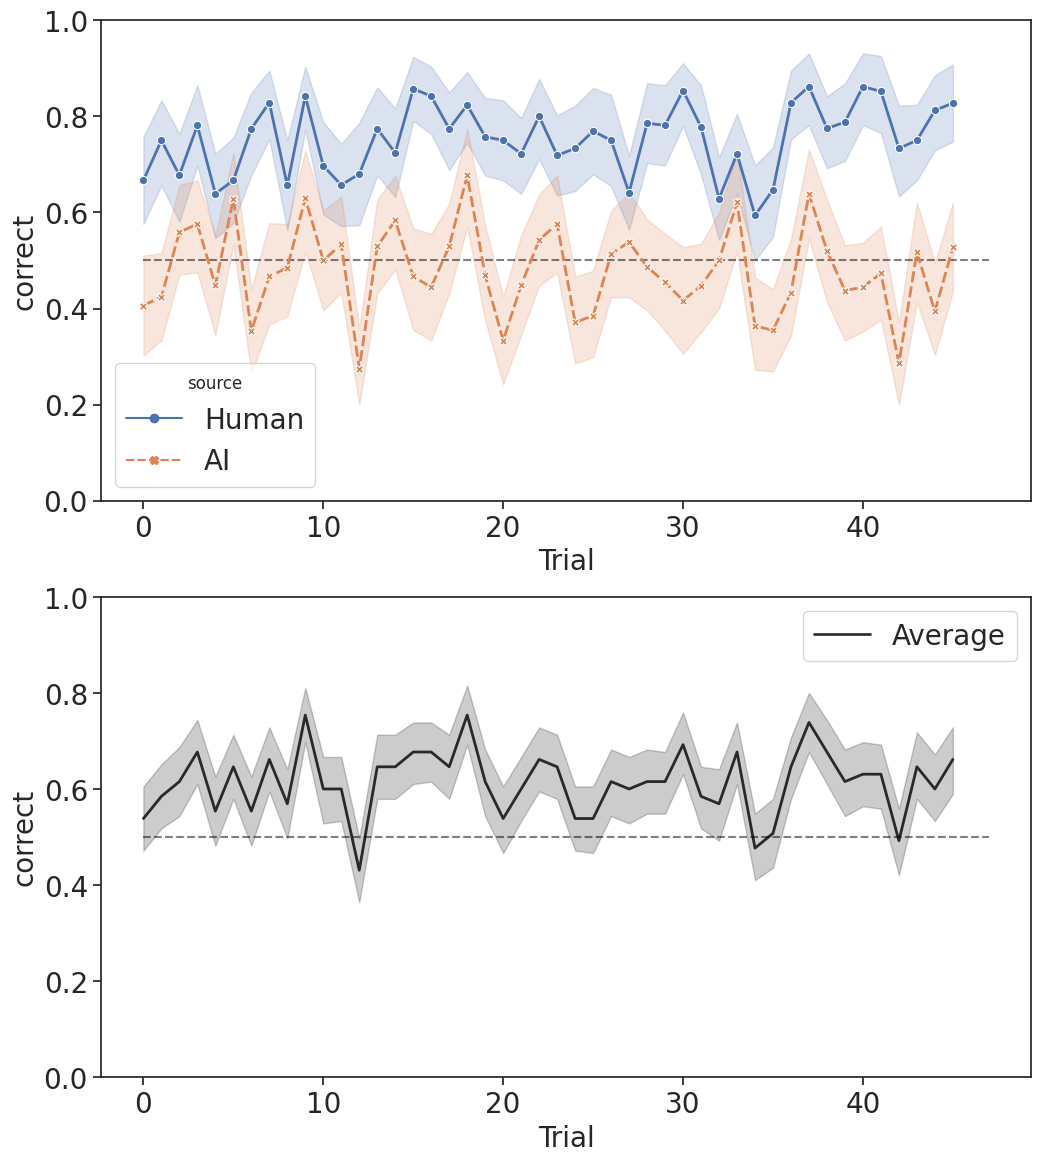

In [86]:
sns.set(
    rc={'figure.figsize':(12, 14), "figure.dpi": 100, 'legend.fontsize': 20,
        'axes.labelsize': 20, 'axes.titlesize': 20, 'xtick.labelsize': 20,
        'ytick.labelsize': 20, 'font.family': 'sans-serif',
        'font.sans-serif': 'Arial', 'text.usetex': False}
)

sns.set_palette('deep')
sns.set_style("ticks")

df2 = df[df.engine=='dv2_prolific']

# ----------------------------------------------------------------------------------------------------------------------
# PLOT 1
# ----------------------------------------------------------------------------------------------------------------------
plt.subplot(2, 1, 1)
plt.plot([0, 47], [0.5, 0.5], '--', color='black', alpha=0.5)
sns.lineplot(x='item_idx', y='correct', data=df2, hue='source',  legend=True, linewidth=2, markers=True, style='source')
plt.ylim(0, 1)
plt.xlabel('Trial')

# ----------------------------------------------------------------------------------------------------------------------
# PLOT 2
# ----------------------------------------------------------------------------------------------------------------------
plt.subplot(2, 1, 2)
plt.plot([0, 47], [0.5, 0.5], '--', color='black', alpha=0.5)
sns.lineplot(x='item_idx', y='correct', data=df2, color='black', linewidth=2, alpha=0.8, label='Average')
# sns.lineplot(x='item_idx', y='agree1', data=df,  legend=False, linewidth=2)
plt.ylim(0, 1)
plt.xlabel('Trial')

Text(0.2, 0.5, 'corr=0.51')

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial


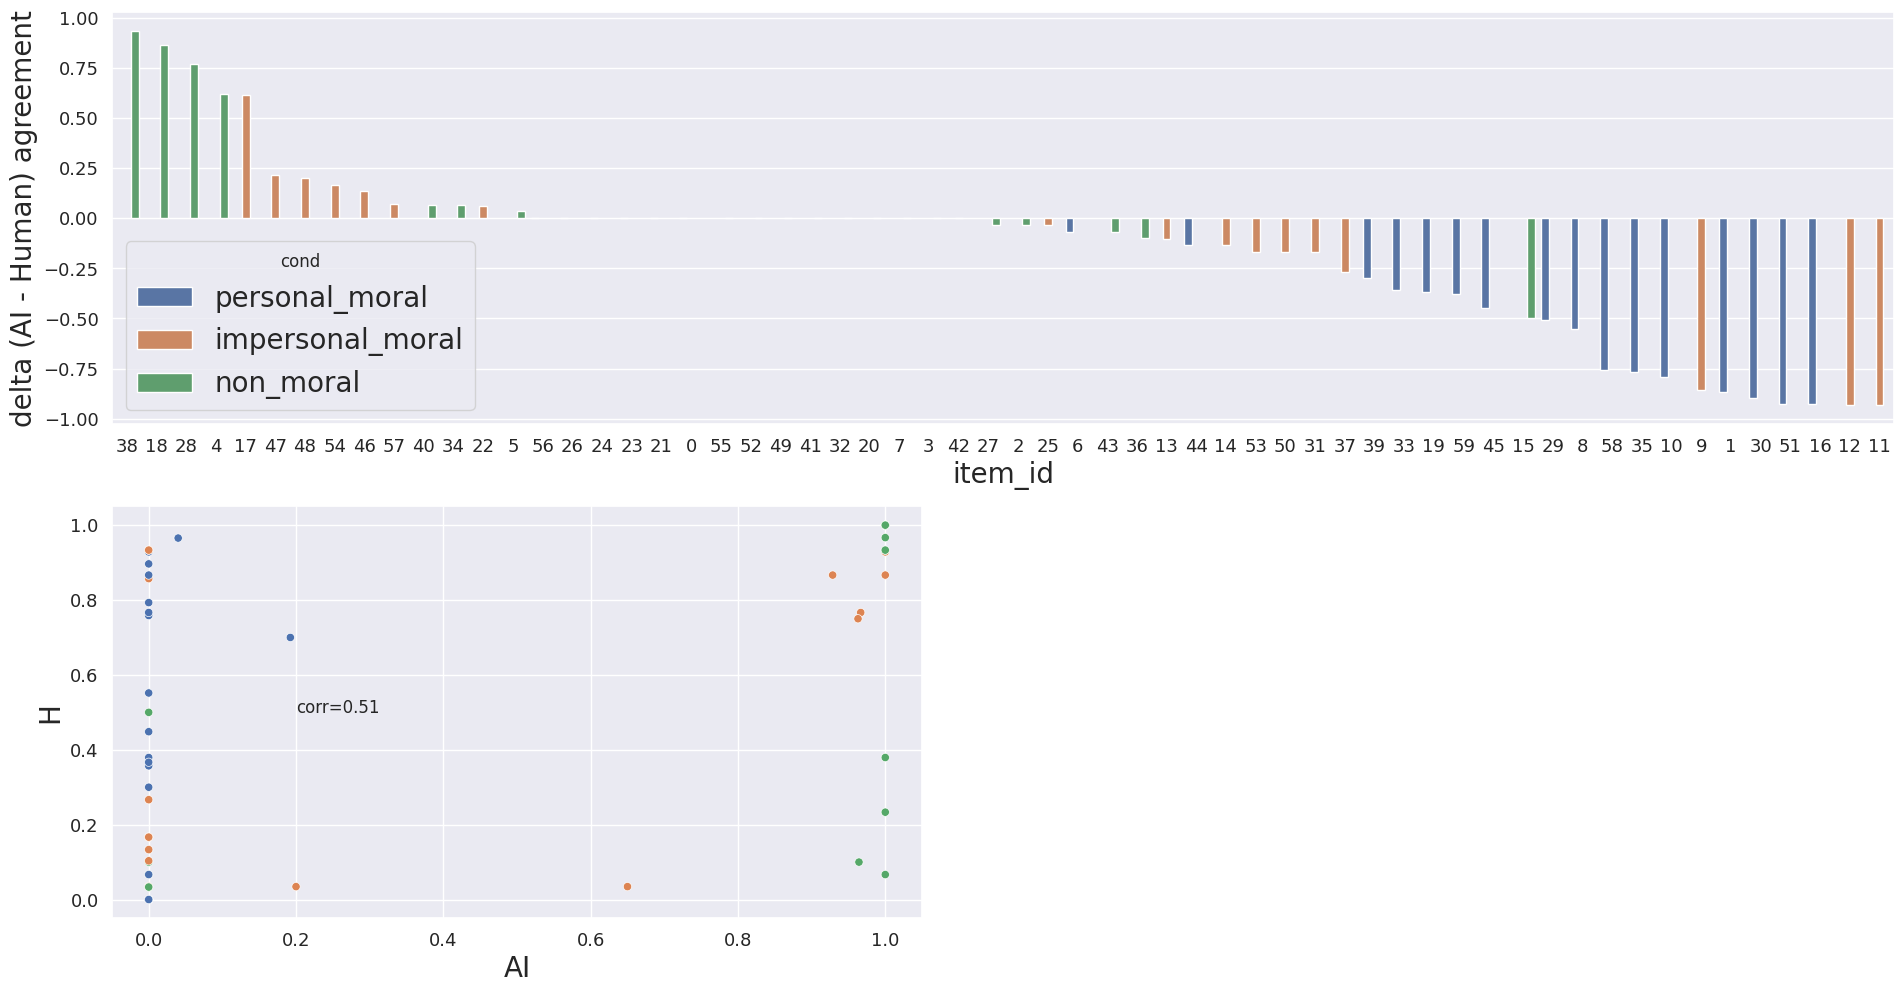

In [7]:
df = pd.read_csv('HUMANS/dv3_all_final.csv')
sns.set(
    rc={'figure.figsize':(23,12), "figure.dpi": 100, 'legend.fontsize': 20,
        'axes.labelsize': 20, 'axes.titlesize': 20,
        'xtick.labelsize': 13
        , 'ytick.labelsize': 13, 'font.family': 'sans-serif',
        'font.sans-serif': 'Arial', 'text.usetex': False})
df['agree_a0'] = df.a0.str.contains('yes')
df_AI = df[df.source=='AI'].groupby(['title', 'cond'], as_index=False).agree_a0.mean().sort_anguavalues('title', ascending=False).rename(columns={'agree_a0': 'AI'})
df_Human = df[df.source=='Human'].groupby(['title', 'cond'], as_index=False).agree_a0.mean().sort_values('title', ascending=False).rename(columns={'agree_a0': 'H'})
diff = pd.concat([df_AI, df_Human.H], axis=1)
diff['diff'] = diff.AI - diff.H
# df_AI.drop('item_id', axis=1, inplace=True)
# df_Human.drop('item_id', axis=1, inplace=True)
# corr.corr()
diff['item_id'] = diff.index


plt.subplot(2, 1, 1)
sns.barplot(x='item_id', y='diff', data=diff, hue='cond', order=diff.sort_values(['diff', 'cond'], ascending=False).index)
plt.ylabel('delta (AI - Human) agreement')
# sns.heatmap(abs(df_AI.AI - df_Human.H), annot=True, cmap='RdBu_r', center=0, vmin=-1, vmax=1, cbar=False)

plt.subplot(2, 2, 3)
sns.scatterplot(x='AI', y='H', data=diff, hue='cond', legend=False)
plt.annotate(f'corr={round(diff.corr().H.values[0], 2)}', xy=(.2, .5))


/tmp/ipykernel_4601/3225731875.py:12: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('png')


<AxesSubplot:>

(0.0, 1.0)

(-0.1, 1.1)

([<matplotlib.axis.XTick at 0x7f20a266ea00>,
 [Text(0, 0, ''), Text(1, 0, '')])

Text(0.5, 0, '')

Text(0.5, 1.0, 'Turing Test Accuracy')

([], [])

               T  dof alternative         p-val           CI95%   cohen-d  \
T-test -8.855215   34   two-sided  2.383803e-10  [-0.42, -0.27]  2.107954   

             BF10  power  
T-test  4.438e+07    1.0  
               T  dof alternative     p-val          CI95%   cohen-d   BF10  \
T-test  1.165204   68   two-sided  0.248008  [-0.02, 0.09]  0.278537  0.439   

           power  
T-test  0.209572  
                T  dof alternative         p-val           CI95%   cohen-d  \
T-test -12.253281   68   two-sided  7.088359e-19  [-0.36, -0.26]  2.929095   

             BF10  power  
T-test  4.469e+15    1.0  


<AxesSubplot:>

(0.0, 1.0)

(-0.1, 1.1)

([<matplotlib.axis.XTick at 0x7f20a29a5fa0>,
 [Text(0, 0, ''), Text(1, 0, '')])

Text(0.5, 0, '')

Text(0.5, 1.0, 'Agreement (Yes/No)')

([], [])

               T  dof alternative     p-val          CI95%   cohen-d   BF10  \
T-test -1.615227   34   two-sided  0.115505  [-0.09, 0.01]  0.375925  0.589   

           power  
T-test  0.579649  


<AxesSubplot:>

(-0.1, 1.1)

Text(0.5, 1.0, 'Agreement (Justification)')

([<matplotlib.axis.XTick at 0x7f20a295dd90>,
 [Text(0, 0, ''), Text(1, 0, '')])

Text(0.5, 0, '')

([], [])

([], [])

               T  dof alternative     p-val         CI95%   cohen-d   BF10  \
T-test -1.047463   34   two-sided  0.302276  [-0.1, 0.03]  0.230959  0.301   

           power  
T-test  0.264182  


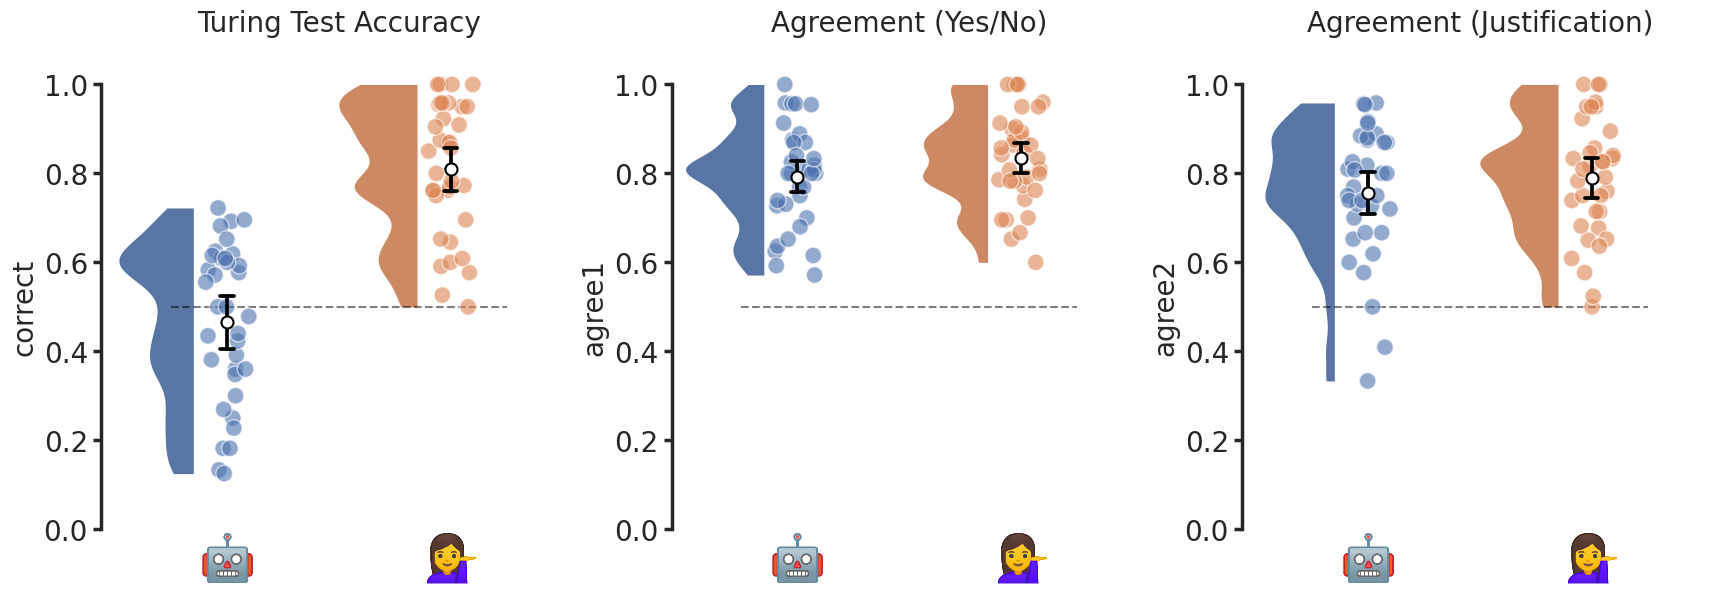

In [21]:
sns.set(
    rc={'figure.figsize':(23,6), "figure.dpi": 100, 'legend.fontsize': 20,
        'axes.labelsize': 20, 'axes.titlesize': 20,
        'xtick.labelsize': 20, 'ytick.labelsize': 20, 'font.family': 'sans-serif',
        'font.sans-serif': 'Arial', 'text.usetex': False})
# set S2 as default style
# sns.set_palette('Set2')
sns.set_palette('deep')
sns.set_style("ticks")

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png')
plt.rcParams['ytick.major.width'] = 2.5
plt.rcParams['xtick.major.width'] = 2.5


# -------------------------------------------------------------------------------
# Plot 1: Turing Test 
# -------------------------------------------------------------------------------
avg = df[(df.engine=='dv2_prolific')& (df.q_id==2)].groupby(['prolific_id', 'source'], as_index=False).mean()
plt.subplot(1, 4, 1)
# sns.barplot(x='source', y='correct', data=avg, errorbar='se'
# sns.stripplot(x='source', y='correct', data=avg, alpha=0.5, jitter=0.1, size=15, color='black')
#
plt.plot([-0.25, 1.25], [0.5, 0.5], '--', color='black', alpha=0.5)
raincloud(x='source', y='correct', markersize=12, df=avg, order=['AI', 'Human'])
plt.ylim(0, 1)
plt.ylim(-.1, 1.1)
plt.xticks(range(2), ('', ''))
plt.xlabel('')
plt.title('Turing Test Accuracy')
plt.xticks([])
plt.gca().spines['left'].set_linewidth(2.5)
for i, c in enumerate(avg.source.unique()):
    offset_image(i, c, plt.gca(), size=0.3)
sns.despine(offset=10, trim=True, bottom=True);

# AI correct and Human correct is significantly diff
print(pg.ttest(avg[avg.source=='AI'].correct, avg[avg.source=='Human'].correct, paired=True))
n = len(avg[avg.source=='AI'].correct)
print(pg.ttest(x=np.ones(n) * .5, y=avg[avg.source=='AI'].correct))
print(pg.ttest(x=np.ones(n) * .5, y=avg[avg.source=='Human'].correct))

# -------------------------------------------------------------------------------
# Plot 2: Agreement 1
# -------------------------------------------------------------------------------
avg = df[(df.engine=='dv2_prolific') & (df.q_id==0)].groupby(['prolific_id', 'source'], as_index=False).mean()
plt.subplot(1, 4, 2)
plt.plot([-0.25, 1.25], [0.5, 0.5], '--', color='black', alpha=0.5)
raincloud(x='source', y='agree1', markersize=12, df=avg, order=['AI', 'Human'])
# sns.barplot(x='source', y='agree1', data=avg, errorbar='se')
# sns.stripplot(x='source', y='agree1', data=avg, color='black', alpha=0.5, jitter=0.1, size=15)
plt.ylim(0, 1)
plt.ylim(-.1, 1.1)
plt.xticks(range(2), ('', ''))
plt.xlabel('')
plt.title('Agreement (Yes/No)')
plt.xticks([])
plt.gca().spines['left'].set_linewidth(2.5)
for i, c in enumerate(avg.source.unique()):
    offset_image(i, c, plt.gca(), size=0.3)
sns.despine(offset=10, trim=True, bottom=True);
# AI agree1 and Human agree1 is significantly diff
print(pg.ttest(avg[avg.source=='AI'].agree1, avg[avg.source=='Human'].agree1, paired=True))
# n = len(avg[avg.source=='AI'].correct)
# print(pg.ttest(x=np.ones(n) * .5, y=avg[avg.source=='AI'].correct))
# print(pg.ttest(x=np.ones(n) * .5, y=avg[avg.source=='Human'].correct))

# -------------------------------------------------------------------------------
# Plot 3: Agreement 2
# -------------------------------------------------------------------------------
avg = df[(df.engine=='dv2_prolific') & df.q_id==1].groupby(['prolific_id', 'source'], as_index=False).mean()
plt.subplot(1, 4, 3)
plt.plot([-0.25, 1.25], [0.5, 0.5], '--', color='black', alpha=0.5)
raincloud(x='source', y='agree2', markersize=12, df=avg, order=['AI', 'Human'])
# sns.barplot(x='source', y='agree2', data=avg, errorbar='se')
# sns.stripplot(x='source', y='agree2', data=avg, color='black', alpha=0.5, jitter=0.1, size=15)
plt.ylim(-.1, 1.1)
plt.title('Agreement (Justification)')
plt.xticks(range(2), ('', ''))
plt.xlabel('')
plt.xticks([])
for i, c in enumerate(avg.source.unique()):
    offset_image(i, c, plt.gca(), size=0.3)
sns.despine(offset=10, trim=True, bottom=True);
plt.gca().spines['left'].set_linewidth(2.5)
plt.xticks([])
# AI agree2 and Human agree2 is significantly diff
print(pg.ttest(avg[avg.source=='AI'].agree2, avg[avg.source=='Human'].agree2, paired=True))


# -------------------------------------------------------------------------------
# Plot 4: RT
# -------------------------------------------------------------------------------
#avg = df.groupby(['prolific_id', 'source'], as_index=False).mean()
#plt.subplot(1, 4, 4)
## plt.plot([-0.25, 1.25], [0.5, 0.5], '--', color='black', alpha=0.5)
## plt.plot([-1, 2], [0.5, 0.5], '--', color='black', alpha=0.5)
##sns.barplot(x='source', y='rt', data=avg, errorbar='se')
##sns.stripplot(x='source', y='rt', data=avg, color='black', alpha=0.5, jitter=0.1, size=15)
#raincloud(x='source', y='rt', markersize=12, df=avg, order=['AI', 'Human'])
#plt.ylim(0, 100000)
#plt.title('RT (ms)')
#plt.xlabel('')
#sns.despine(offset=10, trim=True, bottom=True);
#plt.xticks([])
#plt.gca().spines['left'].set_linewidth(2.5)
#for i, c in enumerate(avg.source.unique()):
#    offset_image(i, c, plt.gca(), size=0.3)
#
plt.tight_layout()

# ADD CORRECTNESS SCORE

In [38]:

with ltp.LanguageTool('en-US', remote_server='http://localhost:8081') as tool:
    x = 'insider trading is ilegal because it gives individuals an unfair advantage in the stock market. it allows them to make trades based on information that is not available to the general public. this gives them an advantage over other investors and can result in significant losses for those who are not privy to the information.'
    matches = [m for m in tool.check(x) if m.category not in ('CASING', 'REDUNDANCY')]
    print(matches)

[Match({'ruleId': 'MORFOLOGIK_RULE_EN_US', 'message': 'Possible spelling mistake found.', 'replacements': ['legal', 'illegal', 'i legal'], 'offsetInContext': 19, 'context': 'insider trading is ilegal because it gives individuals an unfair ...', 'offset': 19, 'errorLength': 6, 'category': 'TYPOS', 'ruleIssueType': 'misspelling', 'sentence': 'insider trading is ilegal because it gives individuals an unfair advantage in the stock market.'})]


In [39]:
unique_a1 = df.a1.unique()
new_df = pd.DataFrame({'a1': unique_a1, 'correctness': [None, ]*len(unique_a1)})
with ltp.LanguageTool('en-US', remote_server='http://localhost:8081') as tool:
    new_df['correctness'] = new_df.a1.apply(lambda x: len([m for m in tool.check(x) if m.category in ('TYPOS', 'GRAMMAR', 'PUNCTUATION')]))
print('Finished checking correctness, apply to dv2 and dv3')
dv2['correctness'] = dv2.a1.apply(lambda x: new_df[new_df.a1==x].correctness.values[0])
dv3['correctness'] = dv3.a1.apply(lambda x: new_df[new_df.a1==x].correctness.values[0])
dv2.to_csv('HUMANS/dv2_77.csv')
dv3.to_csv('HUMANS/dv3_76.csv')

Finished checking correctness, apply to dv2 and dv3


<AxesSubplot:xlabel='source', ylabel='correctness'>

<AxesSubplot:xlabel='source', ylabel='correctness'>

Text(0, 0.5, 'Errors')

(0.0, 6.0)

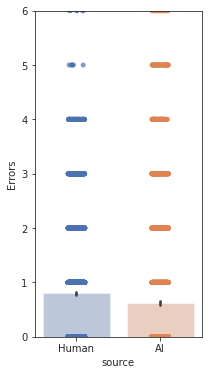

In [41]:
sns.set({'figure.figsize': (3, 6)})
sns.set_style('ticks')
sns.barplot(x='source', y='correctness', data=dv2, alpha=0.4)
sns.stripplot(x='source', y='correctness', data=dv2, alpha=0.7, jitter=0.1, size=5, zorder=1)
plt.ylabel('Errors')
plt.ylim(0, 6)

/tmp/ipykernel_236364/2193031363.py:14: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('png')
/tmp/ipykernel_236364/2193031363.py:47: RuntimeWarning: invalid value encountered in double_scalars
  'd_prime': float(stats.norm.ppf(hits['id'].values[i]) - stats.norm.ppf(false['id'].values[i]))})


<AxesSubplot:xlabel='engine', ylabel='d_prime'>

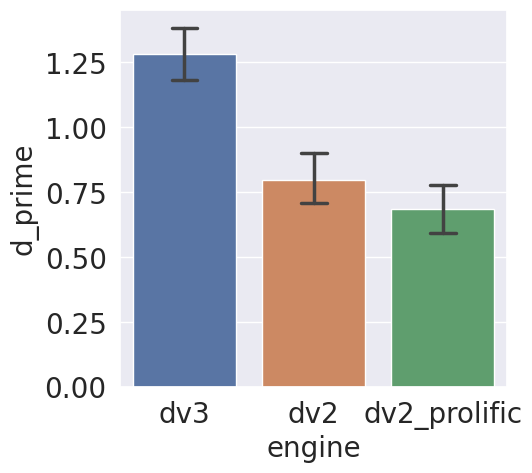

<AxesSubplot:>

(-3.0, 3.0)

Text(0.5, 1.0, 'Agreement (Yes/No)')

           n         r         CI95%     p-val   BF10     power
pearson  195 -0.063062  [-0.2, 0.08]  0.381124  0.131  0.141578
                            OLS Regression Results                            
Dep. Variable:                 agree1   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.7706
Date:                Fri, 10 Mar 2023   Prob (F-statistic):              0.381
Time:                        17:31:26   Log-Likelihood:                 147.67
No. Observations:                 195   AIC:                            -291.3
Df Residuals:                     193   BIC:                            -284.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
---

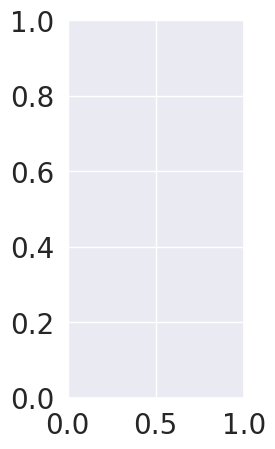

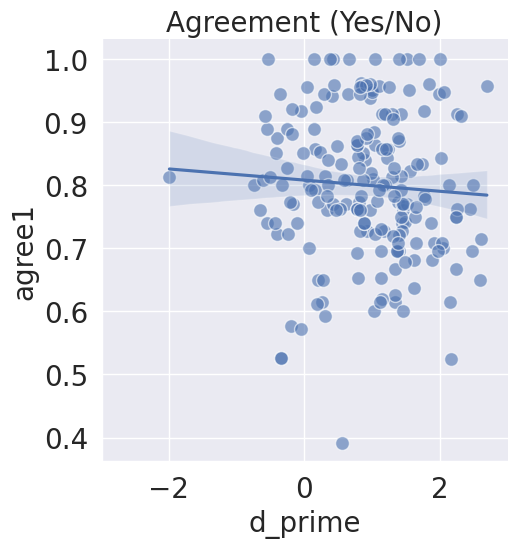

<AxesSubplot:>

(-3.0, 3.0)

Text(0.5, 1.0, 'Agreement (Justification)')

           n         r          CI95%     p-val   BF10    power
pearson  195 -0.091696  [-0.23, 0.05]  0.202338  0.201  0.24783
                            OLS Regression Results                            
Dep. Variable:                 agree2   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     1.637
Date:                Fri, 10 Mar 2023   Prob (F-statistic):              0.202
Time:                        17:31:26   Log-Likelihood:                 112.59
No. Observations:                 195   AIC:                            -221.2
Df Residuals:                     193   BIC:                            -214.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
---

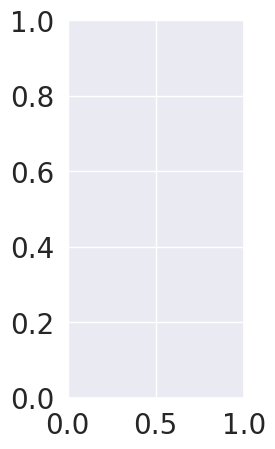

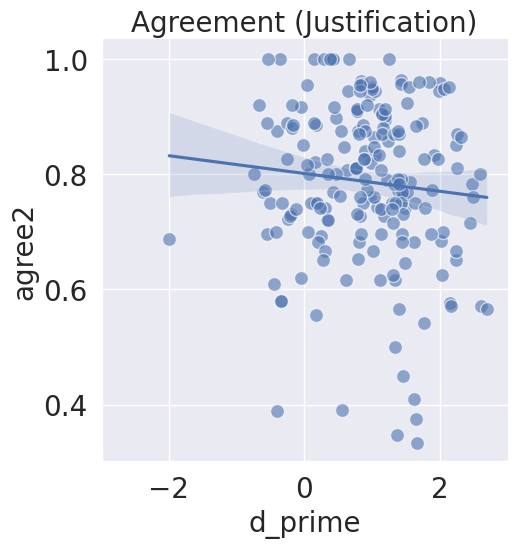

In [87]:
import scipy.stats as stats

sns.set(
    rc={'figure.figsize':(23,6), "figure.dpi": 100, 'legend.fontsize': 20,
        'axes.labelsize': 20, 'axes.titlesize': 20,
        'xtick.labelsize': 20, 'ytick.labelsize': 20, 'font.family': 'sans-serif',
        'font.sans-serif': 'Arial', 'text.usetex': False})
# set S2 as default style
# sns.set_palette('Set2')
sns.set_palette('deep')
sns.set_style("ticks")

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png')
plt.rcParams['ytick.major.width'] = 2.5
plt.rcParams['xtick.major.width'] = 2.5

false = pd.DataFrame()
hits = pd.DataFrame()

labels = ['id', 'agree1', 'agree2']
labels = ['id']
titles = ['Agreement (Yes/No)', 'Agreement (Justification)']

false['id'] = 1 - df[(df.source == 'Human') & (df.q_id == 2)
                     ].groupby('prolific_id', as_index=False).mean().correct
false['engine'] = df[(df.source == 'Human') & (df.q_id == 2)].groupby(['prolific_id', 'engine'], as_index=False).mean().engine
hits['id'] = df[(df.source == 'AI') & (df.q_id == 2)].groupby(
    'prolific_id', as_index=False).mean().correct
hits['engine'] = df[(df.source == 'AI') & (df.q_id == 2)].groupby(['prolific_id', 'engine'],as_index=False).mean().engine

false['agree1'] = 1 - df[(df.source == 'Human') & (df.q_id == 0)
                         ].groupby('prolific_id', as_index=False).mean().agree1

hits['agree1'] = df[(df.source == 'AI') & (df.q_id == 0)].groupby(
    'prolific_id', as_index=False).mean().agree1
false['agree2'] = 1 - df[(df.source == 'Human') & (df.q_id == 1)
                         ].groupby('prolific_id', as_index=False).mean().agree2
hits['agree2'] = df[(df.source == 'AI') & (df.q_id == 1)].groupby(
    'prolific_id', as_index=False).mean().agree2

d = []
for i in range(false['id'].shape[0]):
    d.append({'agree1': hits['agree1'].values[i],
              'agree2': hits['agree2'].values[i],
              'engine': hits['engine'].values[i],
              'd_prime': float(stats.norm.ppf(hits['id'].values[i]) - stats.norm.ppf(false['id'].values[i]))})

d = pd.DataFrame(d)  # plt.subplot(1, 4, 1)
d = d[~d.isin([np.nan, np.inf, -np.inf]).any(1)]

sns.set({'figure.figsize': (5,5), "figure.dpi": 100, 'legend.fontsize': 20,})
sns.barplot(x='engine', y='d_prime', data=d, ci=68, capsize=0.2, errwidth=2.5, edgecolor='white')
plt.show()

count = 0
d['d_prime'] = d['d_prime'].astype(float)
d['agree1'] = d['agree1'].astype(float)
for agree in ('agree1', 'agree2'):
    count += 1
    # plt.clear()
    plt.subplot(1, 2, count)
    sns.lmplot(x='d_prime', y=agree, data=d, scatter_kws={
               'alpha': 0.6, 's': 100, 'edgecolor': 'white'})
# snspine(offset=10, trim=True)
    plt.gca().spines['left'].set_linewidth(2.5)
    plt.gca().spines['bottom'].set_linewidth(2.5)
    plt.xlim([-3, 3])
    plt.title(titles[count-1])
    print(pg.corr(d['d_prime'], d[agree]))
    print(sm.formula.ols(f'{agree} ~ d_prime', data=d).fit().summary())
    plt.show()


,prolific_id,engine,dataset_id,id_first,item_idx,item_id,q_id,rt,correct,agree1,agree2,agree_both,disagree_both
0,542460e3fdf99b691e6ac927,dv3,56.0,0.622222,22.0,2641.022222,1.0,37601.600000,0.733333,0.755556,0.866667,0.755556,0.133333
1,5483702ffdf99b24c654b810,dv2,28.0,0.543478,22.5,1327.500000,1.0,83746.630435,0.391304,0.760870,0.630435,0.608696,0.217391
2,54b9acd9fdf99b34ce2578f9,dv2,20.0,0.478261,22.5,953.500000,1.0,35265.217391,0.652174,0.782609,0.826087,0.760870,0.152174
3,559cdad9fdf99b66f54b7794,dv3,54.0,0.533333,22.0,2549.466667,1.0,79184.800000,0.577778,0.888889,0.888889,0.844444,0.066667
4,55f821f832af740005172118,dv3,21.0,0.555556,22.0,1002.533333,1.0,27315.533333,0.733333,0.888889,0.888889,0.888889,0.111111
...,...,...,...,...,...,...,...,...,...,...,...,...,...
187,63e52bcf0e8f21007fa8308b,dv3,41.0,0.577778,22.0,1947.000000,1.0,22853.711111,0.800000,0.777778,0.822222,0.711111,0.111111
188,63e55ab8223fe6129765e841,dv3,34.0,0.333333,22.0,1618.200000,1.0,44027.644444,0.644444,0.866667,0.822222,0.755556,0.066667
189,63ea44a0adefd2af8e13015c,dv3,36.0,0.555556,22.0,1713.466667,1.0,33814.466667,0.755556,0.866667,0.866667,0.777778,0.044444
190,63ea61d8106e3e2dc14c4cc7,dv3,9.0,0.444444,22.0,441.266667,1.0,31613.622222,0.866667,0.866667,0.844444,0.822222,0.111111


/home/getz/PycharmProjects/CognitiveReflection/venv/lib/python3.8/site-packages/pandas/core/indexing.py:1684: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = infer_fill_value(value)
/home/getz/PycharmProjects/CognitiveReflection/venv/lib/python3.8/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


Optimization terminated successfully.
         Current function value: 0.642511
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                      a   No. Observations:                 4738
Model:                          Logit   Df Residuals:                     4736
Method:                           MLE   Df Model:                            1
Date:                Wed, 08 Feb 2023   Pseudo R-squ.:                 0.04331
Time:                        15:00:28   Log-Likelihood:                -3044.2
converged:                       True   LL-Null:                       -3182.0
Covariance Type:            nonrobust   LLR p-value:                 6.635e-62
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.0239      0.050    -20.647      0.000      -1.121      -0.927
justif_len     0.0034      0.

Text(0, 0, '***')

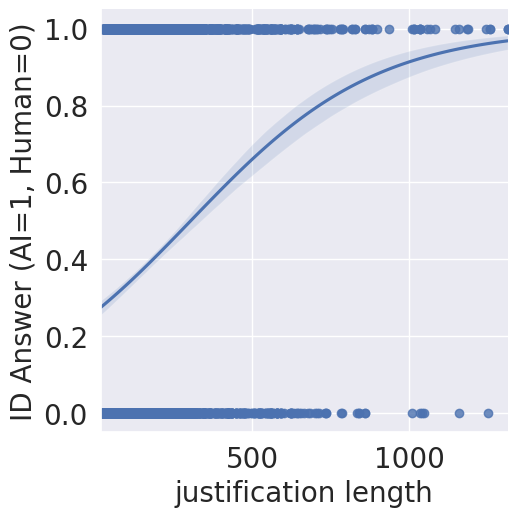

In [ ]:
sns.set({'figure.figsize':(6,6), "figure.dpi": 100, 'legend.fontsize': 20,})
df['justif_len'] = df.a1.str.len()
dff = df[df.q_id == 2]
dff.loc[dff.answer=='AI', 'a'] = 1
dff.loc[dff.answer=='Human', 'a'] = 0


print(sm.Logit.from_formula('a ~ justif_len', data=dff).fit().summary())
sns.lmplot(x='justif_len', y='a', data=dff, logistic=True)
plt.ylabel('ID Answer (AI=1, Human=0)')
plt.xlabel('justification length')
plt.annotate('***', xy=(0, 0), fontsize=20)

<AxesSubplot:ylabel='d_prime'>

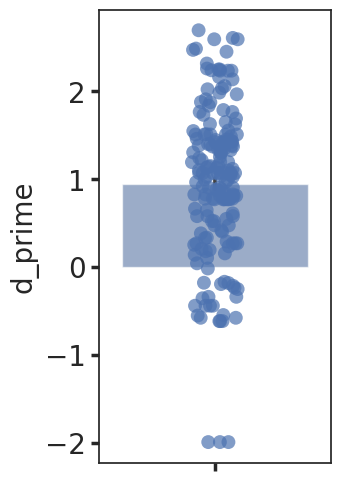

In [ ]:
sns.set({'figure.figsize':(3, 6), 'figure.dpi': 100, 'font.size': 13})
sns.set_style('ticks')
sns.barplot(y='d_prime', data=d, ci=68, alpha=.6)
sns.stripplot(y='d_prime', data=d, size=10, edgecolor='white', alpha=.7)

[(0.2980392156862745, 0.4470588235294118, 0.6901960784313725),
 (0.8666666666666667, 0.5176470588235295, 0.3215686274509804),
 (0.3333333333333333, 0.6588235294117647, 0.40784313725490196),
 (0.7686274509803922, 0.3058823529411765, 0.3215686274509804),
 (0.5058823529411764, 0.4470588235294118, 0.7019607843137254),
 (0.5764705882352941, 0.47058823529411764, 0.3764705882352941),
 (0.8549019607843137, 0.5450980392156862, 0.7647058823529411),
 (0.5490196078431373, 0.5490196078431373, 0.5490196078431373),
 (0.8, 0.7254901960784313, 0.4549019607843137),
 (0.39215686274509803, 0.7098039215686275, 0.803921568627451)]

array(['Human', 'AI', 'Prolific', 'Not Prolific'], dtype=object)

<AxesSubplot:ylabel='answer'>

<AxesSubplot:ylabel='answer'>

<AxesSubplot:ylabel='answer'>

(-0.1, 1.1)

Text(0.5, 1.0, 'Proportion of choice')

([<matplotlib.axis.XTick at 0x7f40f93cb700>,
 [Text(0, 0, ''), Text(1, 0, '')])

Text(0.5, 0, '')

([], [])

([], [])

Text(0.5, 0, 'choice')

([], [])

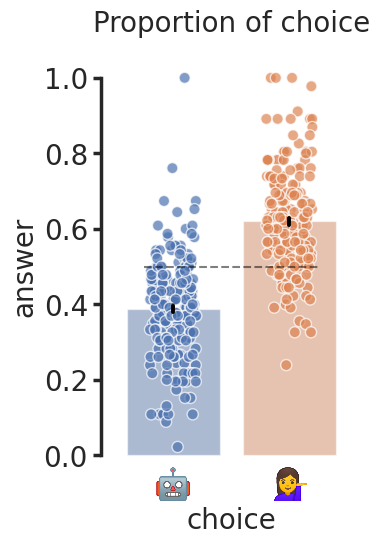

In [104]:

sns.set({'figure.figsize':(3, 6), 'figure.dpi': 100, 'font.size': 13})
sns.set_style('ticks')
sns.color_palette('deep')
# -------------------------------------------------------------------------------
# Plot: Consistency agreement
# -------------------------------------------------------------------------------
# avg = df[df.q_id.isin([0])].groupby(['prolific_id', 'source'], as_index=False).mean()
df[(df.q_id==2)].answer.unique()
df2 = df[df.q_id==2].copy()
df2.loc[df2.answer == 'Not Prolific', 'answer'] = 'AI'
df2.loc[df2.answer == 'Prolific', 'answer'] = 'Human'

x = df2[df2.q_id==2].groupby('prolific_id').answer.value_counts(normalize=True).keys().tolist()
x = [item[1] for item in x]
y = df[df.q_id==2].groupby('prolific_id').answer.value_counts(normalize=True)
plt.plot([-0.25, 1.25], [0.5, 0.5], '--', color='black', alpha=0.5)

# raincloud(x=x, y=y, markersize=12, df=None, order=['AI', 'Human'])
sns.barplot(x=x, y=y, ci=68, alpha=.5, zorder=0)
sns.stripplot(x=x, y=y,  alpha=0.7, jitter=0.2, size=8, linewidth=1, edgecolor='white', zorder=1)
sns.pointplot(x=x, y=y, ci=68, color='black', scale=0, errorbar='se', join=False, zorder=2)
plt.ylim(-.1, 1.1)
plt.title('Proportion of choice')
plt.xticks(range(2), ('', ''))
plt.xlabel('')
plt.xticks([])
sns.despine(offset=10, trim=True, bottom=True);
plt.gca().spines['left'].set_linewidth(2.5)
plt.xticks([])
plt.xlabel('choice')
plt.xticks([])
for i, c in enumerate(avg.source.unique()):
    offset_image(i, c, plt.gca(), size=0.2)



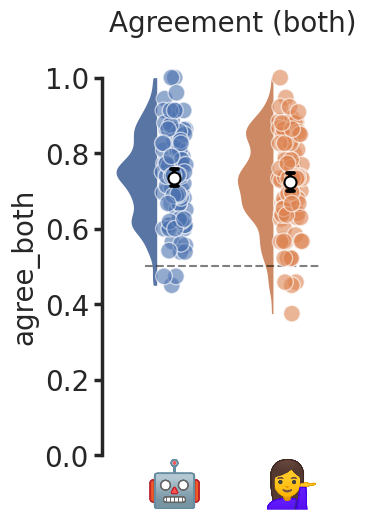

In [ ]:
sns.set_style('ticks')
sns.color_palette('deep')
# -------------------------------------------------------------------------------
# Plot: Consistency agreement
# -------------------------------------------------------------------------------
avg = df[df.q_id.isin([0])].groupby(['prolific_id', 'source'], as_index=False).mean()
plt.plot([-0.25, 1.25], [0.5, 0.5], '--', color='black', alpha=0.5)
raincloud(x='source', y='agree_both', markersize=12, df=avg, order=['AI', 'Human'])
# sns.barplot(x='source', y='agree2', data=avg, errorbar='se')
# sns.stripplot(x='source', y='agree2', data=avg, color='black', alpha=0.5, jitter=0.1, size=15)
plt.ylim(-.1, 1.1)
plt.title('Agreement (both)')
plt.xticks(range(2), ('', ''))
plt.xlabel('')
plt.xticks([])
for i, c in enumerate(avg.source.unique()):
    offset_image(i, c, plt.gca(), size=0.3)
sns.despine(offset=10, trim=True, bottom=True);
plt.gca().spines['left'].set_linewidth(2.5)
plt.xticks([])
plt.xlabel('')
plt.xticks([])
for i, c in enumerate(avg.source.unique()):
    offset_image(i, c, plt.gca(), size=0.3)



([], [])

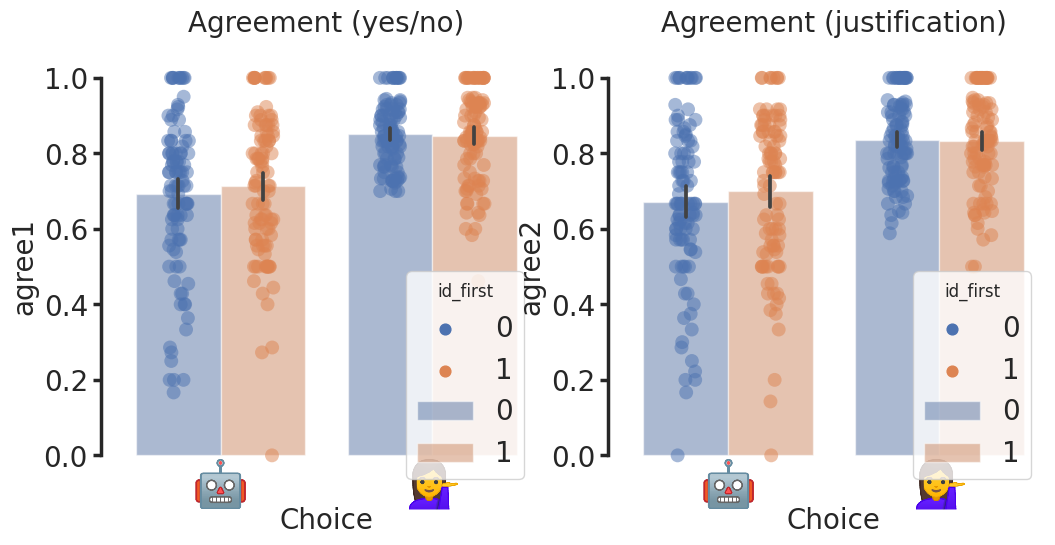

In [ ]:
sns.set({'figure.figsize':(12, 6), 'figure.dpi': 100, 'font.size': 13})
sns.set_style('ticks')
sns.color_palette('deep')
# -------------------------------------------------------------------------------
# Plot:  agreement according to id first
# -------------------------------------------------------------------------------
plt.subplot(1, 2, 1)
avg = df[df.q_id.isin([0])].groupby(['prolific_id', 'turing', 'id_first'], as_index=False).mean()
# plt.plot([-0.25, 1.25], [0.5, 0.5], '--', color='black', alpha=0.5)
# raincloud(x='id_first', y='agree1', markersize=12, df=avg, order=['AI', 'Human'])
sns.barplot(x='turing', y='agree1', data=avg,  hue='id_first', dodge=True, alpha=.5, zorder=0)
g = sns.stripplot(x='turing', y='agree1', data=avg, alpha=0.5, jitter=0.1,
    size=10, hue='id_first', dodge=True, edgecolor='white', zorder=1)
plt.ylim(-.1, 1.1)
plt.title('Agreement (yes/no)')
plt.xlabel('Choice')
for i, c in enumerate(avg.turing.unique()):
    offset_image(i, c, plt.gca(), size=0.3)
sns.despine(offset=10, trim=True, bottom=True);
plt.gca().spines['left'].set_linewidth(2.5)
plt.xticks([])
plt.xticks([])

# -------------------------------------------------------------------------------
# Plot:  agreement justification according to id first
# -------------------------------------------------------------------------------
plt.subplot(1, 2, 2)
avg = df[df.q_id.isin([1])].groupby(['prolific_id', 'turing', 'id_first'], as_index=False).mean()
# plt.plot([-0.25, 1.25], [0.5, 0.5], '--', color='black', alpha=0.5)
# raincloud(x='id_first', y='agree1', markersize=12, df=avg, order=['AI', 'Human'])
sns.barplot(x='turing', y='agree2', data=avg,  hue='id_first', dodge=True, alpha=.5, zorder=0)
g = sns.stripplot(x='turing', y='agree2', data=avg, alpha=0.5, jitter=0.1,
    size=10, hue='id_first', dodge=True, edgecolor='white', zorder=1)
plt.ylim(-.1, 1.1)
plt.title('Agreement (justification)')
for i, c in enumerate(avg.turing.unique()):
    offset_image(i, c, plt.gca(), size=0.3)
sns.despine(offset=10, trim=True, bottom=True);
plt.gca().spines['left'].set_linewidth(2.5)
plt.xticks([])
plt.xlabel('Choice')
plt.xticks([])




<AxesSubplot:xlabel='source', ylabel='dataset_id'>

<AxesSubplot:xlabel='source', ylabel='dataset_id'>

Text(0, 0.5, 'N trials')

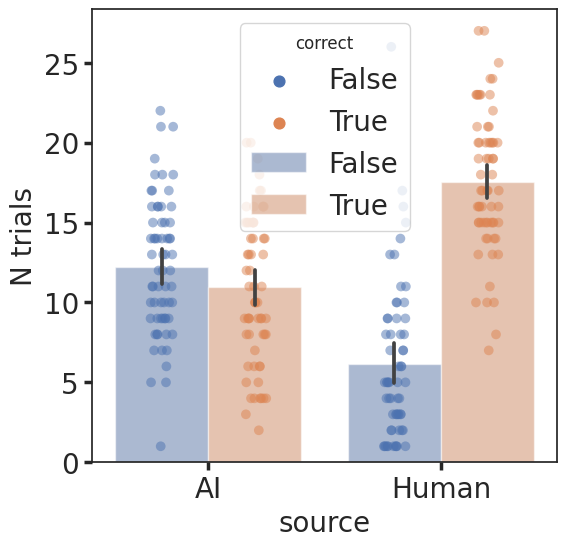

In [107]:
df2 = df[(df.engine=='dv2_prolific') & (df.q_id==2)].groupby(['prolific_id', 'source', 'correct'], as_index=False).count()
sns.set({'figure.figsize':(6, 6), 'figure.dpi': 100, 'font.size': 13})
sns.set_style('ticks')
sns.barplot(x='source', y='dataset_id', data=df2, hue='correct', dodge=True, alpha=.5, zorder=0)
sns.stripplot(x='source', y='dataset_id', data=df2, alpha=0.5, jitter=0.1, size=7, hue='correct', dodge=True, zorder=1)
plt.ylabel('N trials')

Size of dv2 dataset:  100.0


<AxesSubplot:>

<AxesSubplot:xlabel='source', ylabel='agree1'>

<AxesSubplot:xlabel='source', ylabel='agree1'>

(-0.1, 1.1)

Text(0.5, 1.0, 'Agreement 1 (Yes/No)')

([<matplotlib.axis.XTick at 0x7f40f9358100>,
 [Text(0, 0, ''), Text(1, 0, '')])

Text(0.5, 0, '')

([], [])

Text(0.5, 0, 'Source')

ANOVA: VAR=agree1, ENGINE=dv2


,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,ng2,eps
0,source,0.159402,1,70,0.159402,3.391279,6.977885e-02,6.977885e-02,0.011773,1.0
1,correct,0.223693,1,70,0.223693,5.156074,2.624476e-02,2.624476e-02,0.016443,1.0
2,source * correct,2.859813,1,70,2.859813,51.556767,5.853330e-10,5.853330e-10,0.176096,1.0


<AxesSubplot:>

<AxesSubplot:xlabel='source', ylabel='agree2'>

<AxesSubplot:xlabel='source', ylabel='agree2'>

(-0.1, 1.1)

Text(0.5, 1.0, 'Agreement 2 (Justification)')

([<matplotlib.axis.XTick at 0x7f40f92c88b0>,
 [Text(0, 0, ''), Text(1, 0, '')])

Text(0.5, 0, '')

([], [])

ANOVA: VAR=agree2, ENGINE=dv2
             Source        SS  ddof1  ddof2        MS          F  \
0            source  0.277134      1     70  0.277134   5.208443   
1           correct  0.138499      1     70  0.138499   2.842716   
2  source * correct  2.450177      1     70  2.450177  37.054972   

          p-unc     p-GG-corr       ng2  eps  
0  2.552019e-02  2.552019e-02  0.016953  1.0  
1  9.624168e-02  9.624168e-02  0.008545  1.0  
2  5.491172e-08  5.491172e-08  0.132295  1.0  


<AxesSubplot:>

Size of dataset:  3542


<AxesSubplot:xlabel='source', ylabel='agree1'>

<AxesSubplot:xlabel='source', ylabel='agree1'>

(-0.1, 1.1)

Text(0.5, 1.0, 'Agreement 1 (Yes/No)')

([<matplotlib.axis.XTick at 0x7f40f9256130>,
 [Text(0, 0, ''), Text(1, 0, '')])

Text(0.5, 0, '')

([], [])

Text(0.5, 0, 'Source')

ANOVA: 
 VAR=agreement 1 ; ENGINE=dv2_prolific


,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,ng2,eps
0,source,0.006525,1,58,0.006525,0.142948,7.067484e-01,7.067484e-01,0.000580,1.0
1,correct,0.037034,1,58,0.037034,0.993653,3.229919e-01,3.229919e-01,0.003283,1.0
2,source * correct,2.367155,1,58,2.367155,39.027782,5.313252e-08,5.313252e-08,0.173923,1.0


<AxesSubplot:>

<AxesSubplot:xlabel='source', ylabel='agree2'>

<AxesSubplot:xlabel='source', ylabel='agree2'>

(-0.1, 1.1)

Text(0.5, 1.0, 'Agreement 2 (Justification)')

([<matplotlib.axis.XTick at 0x7f40f91d84f0>,
 [Text(0, 0, ''), Text(1, 0, '')])

Text(0.5, 0, '')

([], [])

ANOVA: 
 VAR=agreement 2 ; ENGINE=dv2_prolific
             Source        SS  ddof1  ddof2        MS          F  \
0            source  0.020012      1     58  0.020012   0.417178   
1           correct  0.011527      1     58  0.011527   0.322910   
2  source * correct  4.116988      1     58  4.116988  48.815110   

          p-unc     p-GG-corr       ng2  eps  
0  5.208961e-01  5.208961e-01  0.001366  1.0  
1  5.720577e-01  5.720577e-01  0.000787  1.0  
2  3.084844e-09  3.084844e-09  0.219548  1.0  


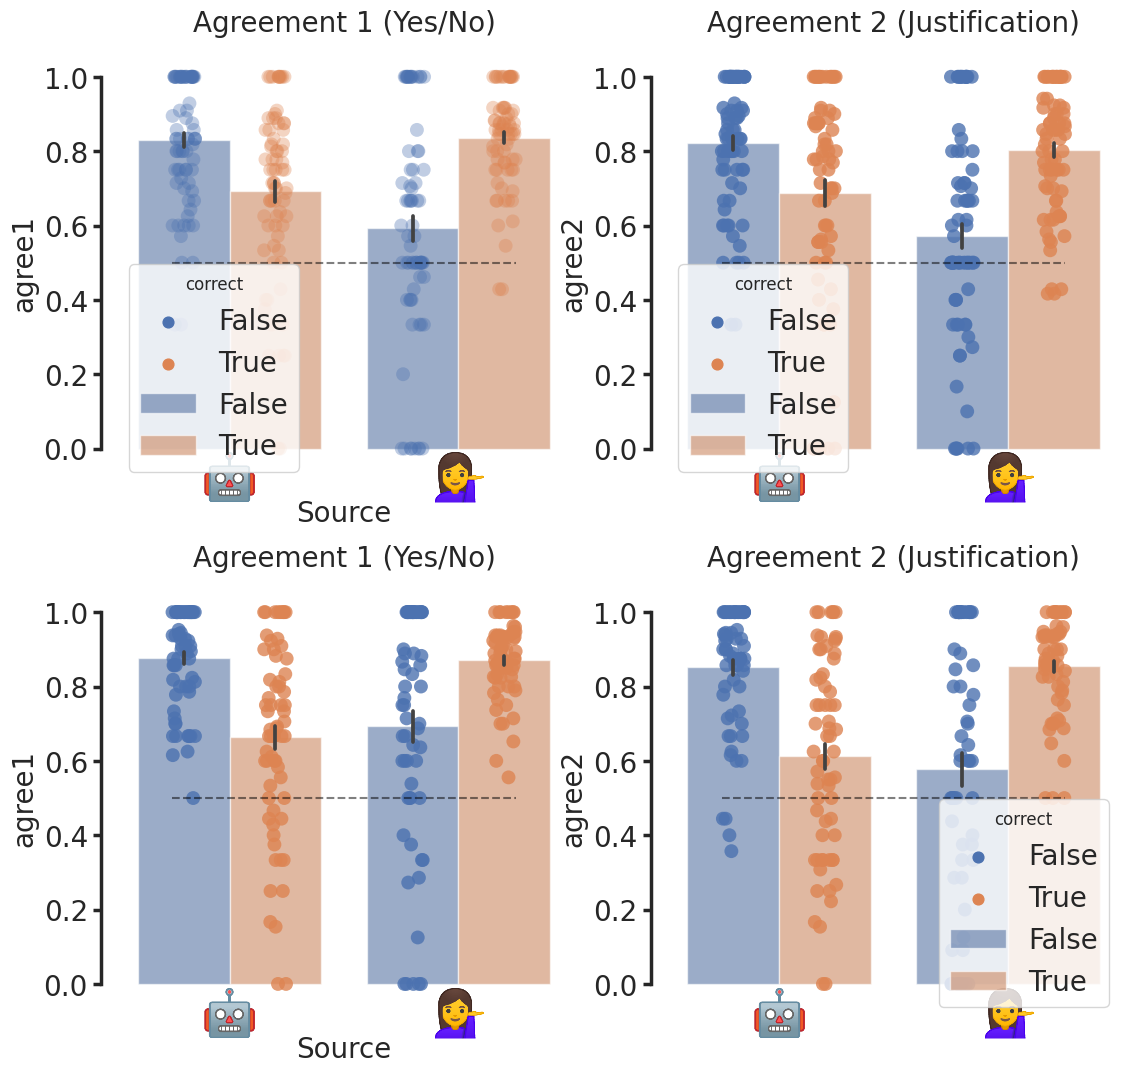

In [106]:
sns.set(
    rc={'figure.figsize':(13,13), "figure.dpi": 100, 'legend.fontsize': 20, 'axes.labelsize': 20, 'axes.titlesize': 20,
      'xtick.labelsize': 20, 'ytick.labelsize': 20, 'font.family': 'sans-serif',
      'font.sans-serif': 'Arial', 'text.usetex': False})
# set S2 as default style
plt.rcParams['ytick.major.width'] = 2.5
plt.rcParams['xtick.major.width'] = 2.5


# sns.set_palette('Set2')
sns.set_palette('deep')
sns.set_style("ticks")

# -------------------------------------------------------------------------------
# Plot:  agreement 1 per correct and source + anova
# -------------------------------------------------------------------------------
engine = 'dv2'
avg = df[(df.engine==engine) & (df.cond!='non_moral') & (df.q_id == 2)].groupby(['prolific_id', 'source', 'correct'], as_index=False).mean()
print(f'Size of {engine} dataset: ', avg.shape[0]/3)

plt.subplot(2, 2, 1)
plt.plot([-0.25, 1.25], [0.5, 0.5], '--', color='black', alpha=0.5)
# raincloud(x='source', y='agree_both', markersize=12, df=avg, order=['AI', 'Human'])
sns.barplot(x='source', y='agree1', data=avg, ci=68, alpha=0.6, hue='correct', zorder=0, dodge=True)
sns.stripplot(x='source', y='agree1', data=avg, alpha=0.35, jitter=0.1, size=10, dodge=True, hue='correct', zorder=1)
plt.ylim(-.1, 1.1)
plt.title('Agreement 1 (Yes/No)')
plt.xticks(range(2), ('', ''))
plt.xlabel('')
plt.xticks([])
for i, c in enumerate(avg.source.unique()):
    offset_image(i, c, plt.gca(), size=0.3)
sns.despine(offset=10, trim=True, bottom=True);
plt.gca().spines['left'].set_linewidth(2.5)
plt.gca().spines['bottom'].set_linewidth(2.5)

plt.xlabel('Source')
# plt.legend([], [], frameon=False)
print('ANOVA: VAR=agree1, ENGINE=dv2')
pg.rm_anova(data=avg, dv='agree1', within=['source', 'correct'], subject='prolific_id', detailed=True)


# -------------------------------------------------------------------------------
# Plot:  agreement 2 per correct and source + anova
# -------------------------------------------------------------------------------
plt.subplot(2, 2, 2)
plt.plot([-0.25, 1.25], [0.5, 0.5], '--', color='black', alpha=0.5)
# raincloud(x='source', y='agree_both', markersize=12, df=avg, order=['AI', 'Human'])
sns.barplot(x='source', y='agree2', data=avg, ci=68, alpha=0.6, hue='correct', zorder=0)
sns.stripplot(x='source', y='agree2', data=avg, alpha=0.8, jitter=0.1, size=10, dodge=True, hue='correct', zorder=1, edgecolor='white')
plt.ylim(-.1, 1.1)
plt.title('Agreement 2 (Justification)')
plt.xticks(range(2), ('', ''))
plt.xlabel('')
plt.xticks([])
for i, c in enumerate(avg.source.unique()):
    offset_image(i, c, plt.gca(), size=0.3)
sns.despine(offset=10, trim=True, bottom=True);
plt.gca().spines['left'].set_linewidth(2.5)
plt.gca().spines['bottom'].set_linewidth(2.5)
# plt.legend([], [], frameon=False)
print('ANOVA: VAR=agree2, ENGINE=dv2')
print(pg.rm_anova(data=avg, dv='agree2', within=['source', 'correct'], subject='prolific_id', detailed=True))

# -------------------------------------------------------------------------------
# Plot:  agreement 2 per correct and source + anova
# -------------------------------------------------------------------------------
plt.subplot(2, 2, 3)
engine = 'dv2_prolific'
avg = df[(df.engine==engine) & (df.q_id==2)].groupby(['prolific_id', 'source', 'correct'], as_index=False).mean()
print('Size of dataset: ', avg.size)
plt.plot([-0.25, 1.25], [0.5, 0.5], '--', color='black', alpha=0.5)
# raincloud(x='source', y='agree_both', markersize=12, df=avg, order=['AI', 'Human'])
sns.barplot(x='source', y='agree1', data=avg, ci=68, alpha=0.6, hue='correct', zorder=0)
sns.stripplot(x='source', y='agree1', data=avg, alpha=0.8, jitter=0.1, size=10, dodge=True, hue='correct', zorder=1, edgecolor='white')
plt.ylim(-.1, 1.1)
plt.title('Agreement 1 (Yes/No)')
plt.xticks(range(2), ('', ''))
plt.xlabel('')
plt.xticks([])
for i, c in enumerate(avg.source.unique()):
    offset_image(i, c, plt.gca(), size=0.3)
sns.despine(offset=10, trim=True, bottom=True);
plt.gca().spines['left'].set_linewidth(2.5)
plt.gca().spines['bottom'].set_linewidth(2.5)
plt.xlabel('Source')
plt.legend([], [], frameon=False)
print('ANOVA: \n VAR=agreement 1 ; ENGINE=dv2_prolific')
pg.rm_anova(data=avg, dv='agree1', within=['source', 'correct'], subject='prolific_id', detailed=True)



plt.subplot(2, 2, 4)
# -------------------------------------------------------------------------------
# Plot:  agreement 2 per correct and source + anova
# -------------------------------------------------------------------------------
plt.plot([-0.25, 1.25], [0.5, 0.5], '--', color='black', alpha=0.5)
# raincloud(x='source', y='agree_both', markersize=12, df=avg, order=['AI', 'Human'])
sns.barplot(x='source', y='agree2', data=avg, ci=68, alpha=0.6, hue='correct', zorder=0)
sns.stripplot(x='source', y='agree2', data=avg, alpha=0.8, jitter=0.1, size=10, dodge=True, hue='correct', zorder=1, edgecolor='white')
plt.ylim(-.1, 1.1)
plt.title('Agreement 2 (Justification)')
plt.xticks(range(2), ('', ''))
plt.xlabel('')
plt.xticks([])
for i, c in enumerate(avg.source.unique()):
    offset_image(i, c, plt.gca(), size=0.3)
sns.despine(offset=10, trim=True, bottom=True);
plt.gca().spines['left'].set_linewidth(2.5)
plt.gca().spines['bottom'].set_linewidth(2.5)
# plt.legend([], [], frameon=False)
print('ANOVA: \n VAR=agreement 2 ; ENGINE=dv2_prolific')
print(pg.rm_anova(data=avg, dv='agree2', within=['source', 'correct'], subject='prolific_id', detailed=True))




        Source        SS  DF1  DF2        MS           F         p-unc  \
0       engine  1.107804    1  169  1.107804   26.123587  8.592556e-07   
1       source  3.269298    1  169  3.269298  126.771792  2.682744e-22   
2  Interaction  0.003793    1  169  0.003793    0.147089  7.018154e-01   

        np2  eps  
0  0.133882  NaN  
1  0.428614  1.0  
2  0.000870  NaN  
        Source        SS  DF1  DF2        MS         F     p-unc       np2  \
0       engine  0.030255    1  169  0.030255  2.516109  0.114558  0.014670   
1       source  0.020445    1  169  0.020445  2.096785  0.149462  0.012255   
2  Interaction  0.001369    1  169  0.001369  0.140378  0.708376  0.000830   

   eps  
0  NaN  
1  1.0  
2  NaN  


/home/getz/PycharmProjects/CognitiveReflection/venv/lib/python3.8/site-packages/pingouin/parametric.py:747: RuntimeWarning: invalid value encountered in double_scalars
  f_a = ms_a / ms_as
/home/getz/PycharmProjects/CognitiveReflection/venv/lib/python3.8/site-packages/pingouin/parametric.py:748: RuntimeWarning: invalid value encountered in double_scalars
  f_b = ms_b / ms_bs
/home/getz/PycharmProjects/CognitiveReflection/venv/lib/python3.8/site-packages/pingouin/parametric.py:749: RuntimeWarning: invalid value encountered in double_scalars
  f_ab = ms_ab / ms_abs
/home/getz/PycharmProjects/CognitiveReflection/venv/lib/python3.8/site-packages/pingouin/parametric.py:764: RuntimeWarning: invalid value encountered in double_scalars
  ef_a = ss_a / (ss_a + ss_s + ss_as + ss_bs + ss_abs)
/home/getz/PycharmProjects/CognitiveReflection/venv/lib/python3.8/site-packages/pingouin/parametric.py:765: RuntimeWarning: invalid value encountered in double_scalars
  ef_b = ss_b / (ss_b + ss_s + ss_as + 

            Source   SS  ddof1  ddof2   MS   F  p-unc  p-GG-corr  ng2  eps
0           source  0.0     -1      1 -0.0 NaN    NaN        NaN  NaN  1.0
1           engine  0.0     -1      1 -0.0 NaN    NaN        NaN  NaN  1.0
2  source * engine  0.0      1     -1  0.0 NaN    NaN        NaN  NaN  NaN


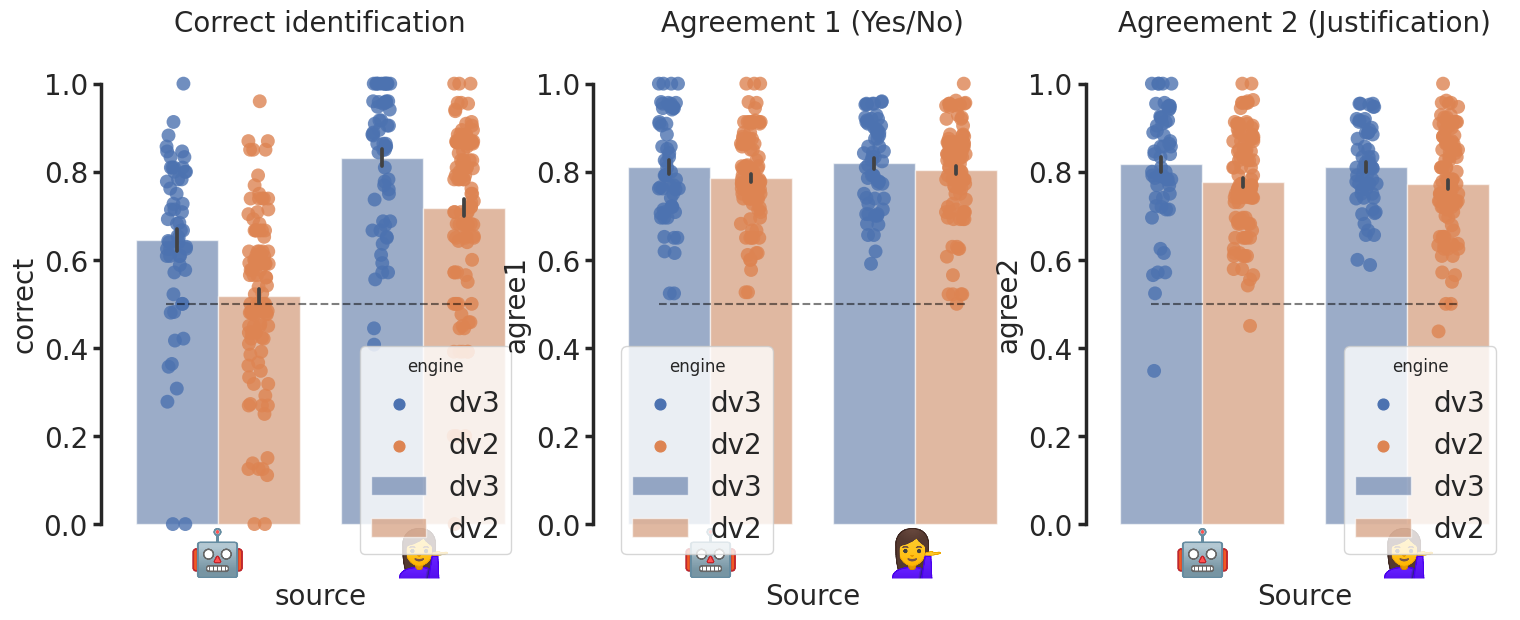

In [ ]:
sns.set(
    rc={'figure.figsize':(18,7), "figure.dpi": 100, 'legend.fontsize': 20, 'axes.labelsize': 20, 'axes.titlesize': 20,
      'xtick.labelsize': 20, 'ytick.labelsize': 20, 'font.family': 'sans-serif',
      'font.sans-serif': 'Arial', 'text.usetex': False})
# set S2 as default style
plt.rcParams['ytick.major.width'] = 2.5
plt.rcParams['xtick.major.width'] = 2.5


# sns.set_palette('Set2')
sns.set_palette('deep')
sns.set_style("ticks")

# -------------------------------------------------------------------------------
# Plot:  agreement 1 per correct and source + anova
# -------------------------------------------------------------------------------

avg = df.groupby(['prolific_id', 'source', 'engine'], as_index=False).mean()

plt.subplot(1, 3, 1)
plt.plot([-0.25, 1.25], [0.5, 0.5], '--', color='black', alpha=0.5)
# raincloud(x='source', y='agree_both', markersize=12, df=avg, order=['AI', 'Human'])
sns.barplot(x='source', y='correct', data=avg, ci=68, alpha=0.6, hue='engine', zorder=0, dodge=True)
sns.stripplot(x='source', y='correct', data=avg, alpha=0.8, jitter=0.1, size=10, dodge=True, hue='engine', zorder=1)
plt.ylim(-.1, 1.1)
plt.title('Correct identification')
plt.xticks(range(2), ('', ''))
plt.xlabel('source')
plt.xticks([])
for i, c in enumerate(avg.source.unique()):
    offset_image(i, c, plt.gca(), size=0.3)
sns.despine(offset=10, trim=True, bottom=True);
plt.gca().spines['left'].set_linewidth(2.5)
plt.gca().spines['bottom'].set_linewidth(2.5)
# plt.legend([], [], frameon=False)
print(pg.mixed_anova(data=avg, dv='correct', within='source', between='engine', subject='prolific_id'))



# -------------------------------------------------------------------------------
# Plot:  agreement 1 per correct and source + anova
# -------------------------------------------------------------------------------

avg = df.groupby(['prolific_id', 'source', 'engine'], as_index=False).mean()

plt.subplot(1, 3, 2)
plt.plot([-0.25, 1.25], [0.5, 0.5], '--', color='black', alpha=0.5)
# raincloud(x='source', y='agree_both', markersize=12, df=avg, order=['AI', 'Human'])
sns.barplot(x='source', y='agree1', data=avg, ci=68, alpha=0.6, hue='engine', zorder=0, dodge=True)
sns.stripplot(x='source', y='agree1', data=avg, alpha=0.8, jitter=0.1, size=10, dodge=True, hue='engine', zorder=1)
plt.ylim(-.1, 1.1)
plt.title('Agreement 1 (Yes/No)')
plt.xticks(range(2), ('', ''))
plt.xlabel('')

plt.xlabel('Source')
plt.xticks([])
for i, c in enumerate(avg.source.unique()):
    offset_image(i, c, plt.gca(), size=0.3)
sns.despine(offset=10, trim=True, bottom=True);
plt.gca().spines['left'].set_linewidth(2.5)
plt.gca().spines['bottom'].set_linewidth(2.5)
# plt.legend([], [], frameon=False)
print(pg.mixed_anova(data=avg, dv='agree1', within='source', between='engine', subject='prolific_id'))


# -------------------------------------------------------------------------------
# Plot:  agreement 2 per correct and source + anova
# -------------------------------------------------------------------------------
plt.subplot(1, 3, 3)
plt.plot([-0.25, 1.25], [0.5, 0.5], '--', color='black', alpha=0.5)
# raincloud(x='source', y='agree_both', markersize=12, df=avg, order=['AI', 'Human'])
sns.barplot(x='source', y='agree2', data=avg, ci=68, alpha=0.6, hue='engine', zorder=0)
sns.stripplot(x='source', y='agree2', data=avg, alpha=0.8, jitter=0.1, size=10, dodge=True, hue='engine', zorder=1, edgecolor='white')
plt.ylim(-.1, 1.1)
plt.title('Agreement 2 (Justification)')
plt.xticks(range(2), ('', ''))
plt.xlabel('')
plt.xticks([])

plt.xlabel('Source')
for i, c in enumerate(avg.source.unique()):
    offset_image(i, c, plt.gca(), size=0.3)
sns.despine(offset=10, trim=True, bottom=True);
plt.gca().spines['left'].set_linewidth(2.5)
plt.gca().spines['bottom'].set_linewidth(2.5)
# plt.legend([], [], frameon=False)
print(pg.rm_anova(data=avg, dv='agree2', within=['source', 'engine'], subject='prolific_id', detailed=True))




Text(0.5, 0.98, 'DV3')

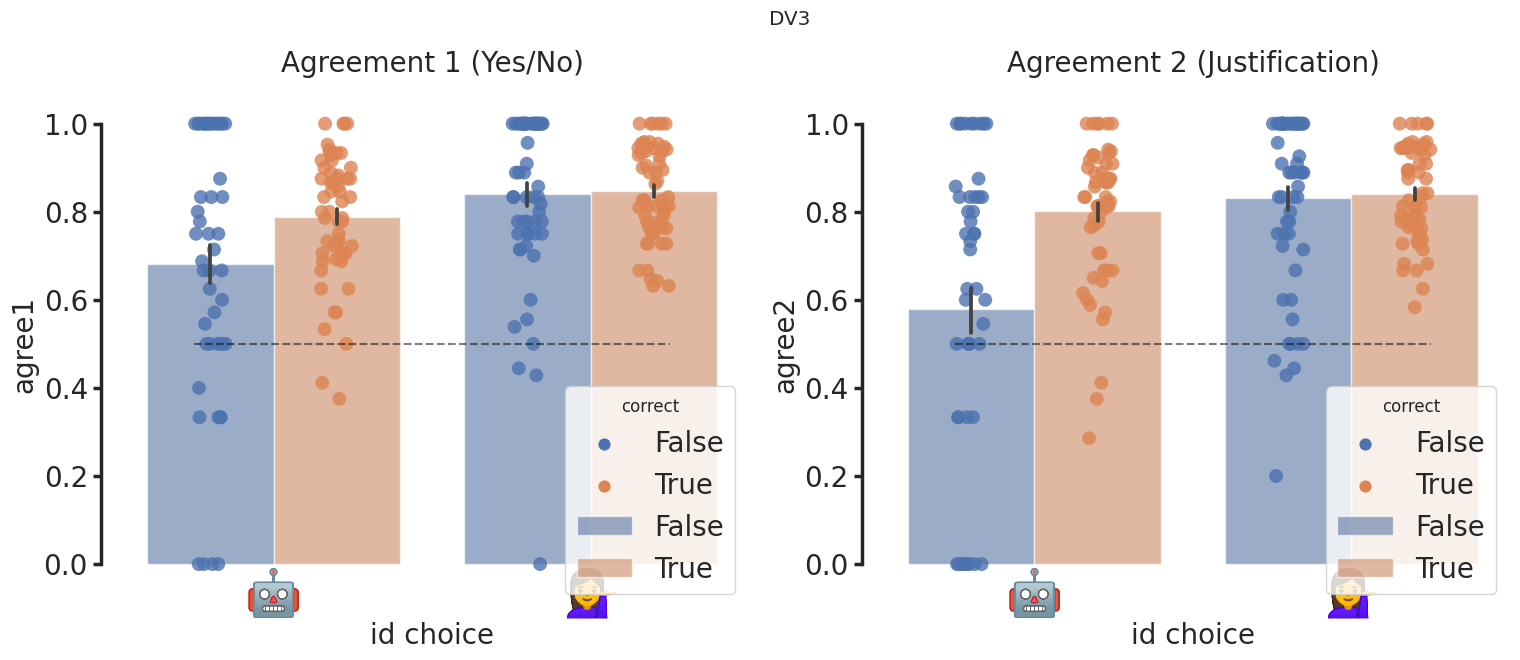

In [ ]:
sns.set(
    rc={'figure.figsize':(18,7), "figure.dpi": 100, 'legend.fontsize': 20, 'axes.labelsize': 20, 'axes.titlesize': 20,
      'xtick.labelsize': 20, 'ytick.labelsize': 20, 'font.family': 'sans-serif',
      'font.sans-serif': 'Arial', 'text.usetex': False})
# set S2 as default style
plt.rcParams['ytick.major.width'] = 2.5
plt.rcParams['xtick.major.width'] = 2.5


# sns.set_palette('Set2')
sns.set_palette('deep')
sns.set_style("ticks")

# -------------------------------------------------------------------------------
# Plot:  agreement 1 per correct and turing + anova
# -------------------------------------------------------------------------------


#plt.subplot(1, 3, 1)
#plt.plot([-0.25, 1.25], [0.5, 0.5], '--', color='black', alpha=0.5)
## raincloud(x='turing', y='agree_both', markersize=12, df=avg, order=['AI', 'Human'])
#sns.barplot(x='turing', y='correct', data=avg, ci=68, alpha=0.6, hue='correct', zorder=0, dodge=True)
#sns.stripplot(x='turing', y='correct', data=avg, alpha=0.8, jitter=0.1, size=10, dodge=True, hue='correct', zorder=1)
#plt.ylim(-.1, 1.1)
#plt.title('Correct identification')
#plt.xticks(range(2), ('', ''))
#plt.xlabel('id choice')
#plt.xticks([])
#for i, c in enumerate(avg.turing.unique()):
#    offset_image(i, c, plt.gca(), size=0.3)
#sns.despine(offset=10, trim=True, bottom=True);
#plt.gca().spines['left'].set_linewidth(2.5)
#plt.gca().spines['bottom'].set_linewidth(2.5)
# plt.legend([], [], frameon=False)
# print(pg.mixed_anova(data=avg, dv='correct', within='turing', between='correct', subject='prolific_id'))



# -------------------------------------------------------------------------------
# Plot:  agreement 1 per correct and turing + anova
# -------------------------------------------------------------------------------

avg = df[df.engine=='dv3'].groupby(['prolific_id', 'turing', 'correct'], as_index=False).mean()

plt.subplot(1, 2, 1)
plt.plot([-0.25, 1.25], [0.5, 0.5], '--', color='black', alpha=0.5)
# raincloud(x='turing', y='agree_both', markersize=12, df=avg, order=['AI', 'Human'])
sns.barplot(x='turing', y='agree1', data=avg, ci=68, alpha=0.6, hue='correct', zorder=0, dodge=True)
sns.stripplot(x='turing', y='agree1', data=avg, alpha=0.8, jitter=0.1, size=10, dodge=True, hue='correct', zorder=1)
plt.ylim(-.1, 1.1)
plt.title('Agreement 1 (Yes/No)')
plt.xticks(range(2), ('', ''))

plt.xlabel('id choice')
plt.xticks([])
for i, c in enumerate(avg.turing.unique()):
    offset_image(i, c, plt.gca(), size=0.3)
sns.despine(offset=10, trim=True, bottom=True);
plt.gca().spines['left'].set_linewidth(2.5)
plt.gca().spines['bottom'].set_linewidth(2.5)
# plt.legend([], [], frameon=False)
# print(pg.mixed_anova(data=avg, dv='agree1', within='turing', between='correct', subject='prolific_id'))


# -------------------------------------------------------------------------------
# Plot:  agreement 2 per correct and turing + anova
# -------------------------------------------------------------------------------
plt.subplot(1, 2, 2)
plt.plot([-0.25, 1.25], [0.5, 0.5], '--', color='black', alpha=0.5)
# raincloud(x='turing', y='agree_both', markersize=12, df=avg, order=['AI', 'Human'])
sns.barplot(x='turing', y='agree2', data=avg, ci=68, alpha=0.6, hue='correct', zorder=0)
sns.stripplot(x='turing', y='agree2', data=avg, alpha=0.8, jitter=0.1, size=10, dodge=True, hue='correct', zorder=1, edgecolor='white')
plt.ylim(-.1, 1.1)
plt.title('Agreement 2 (Justification)')
plt.xticks(range(2), ('', ''))
plt.xlabel('')
plt.xticks([])

plt.xlabel('id choice')
for i, c in enumerate(avg.turing.unique()):
    offset_image(i, c, plt.gca(), size=0.3)
sns.despine(offset=10, trim=True, bottom=True);
plt.gca().spines['left'].set_linewidth(2.5)
plt.gca().spines['bottom'].set_linewidth(2.5)
plt.suptitle('DV3')
# plt.legend([], [], frameon=False)
# print(pg.rm_anova(data=avg, dv='agree2', within=['turing', 'correct'], subject='prolific_id', detailed=True))




In [ ]:
df.groupby(['prolific_id', 'source', 'correct'], as_index=False).size()


,prolific_id,source,correct,size
0,542460e3fdf99b691e6ac927,AI,True,51
1,542460e3fdf99b691e6ac927,Human,False,36
2,542460e3fdf99b691e6ac927,Human,True,48
3,5483702ffdf99b24c654b810,AI,False,45
4,5483702ffdf99b24c654b810,AI,True,21
...,...,...,...,...
659,63ea61d8106e3e2dc14c4cc7,Human,True,69
660,63ea627512244090788d46ec,AI,False,12
661,63ea627512244090788d46ec,AI,True,48
662,63ea627512244090788d46ec,Human,False,3


  Source        SS   DF        MS         F     p-unc       ng2       eps
0   cond  0.340806    2  0.170403  7.192593  0.000872  0.024048  0.970557
1  Error  8.055105  340  0.023691       NaN       NaN       NaN       NaN
  Source        SS   DF        MS          F         p-unc     p-GG-corr  \
0   cond  2.099979    2  1.049989  51.383346  3.174503e-20  2.747741e-18   
1  Error  6.947706  340  0.020434        NaN           NaN           NaN   

        ng2       eps sphericity   W-spher   p-spher  
0  0.148092  0.890238      False  0.876705  0.000015  
1       NaN       NaN        NaN       NaN       NaN  


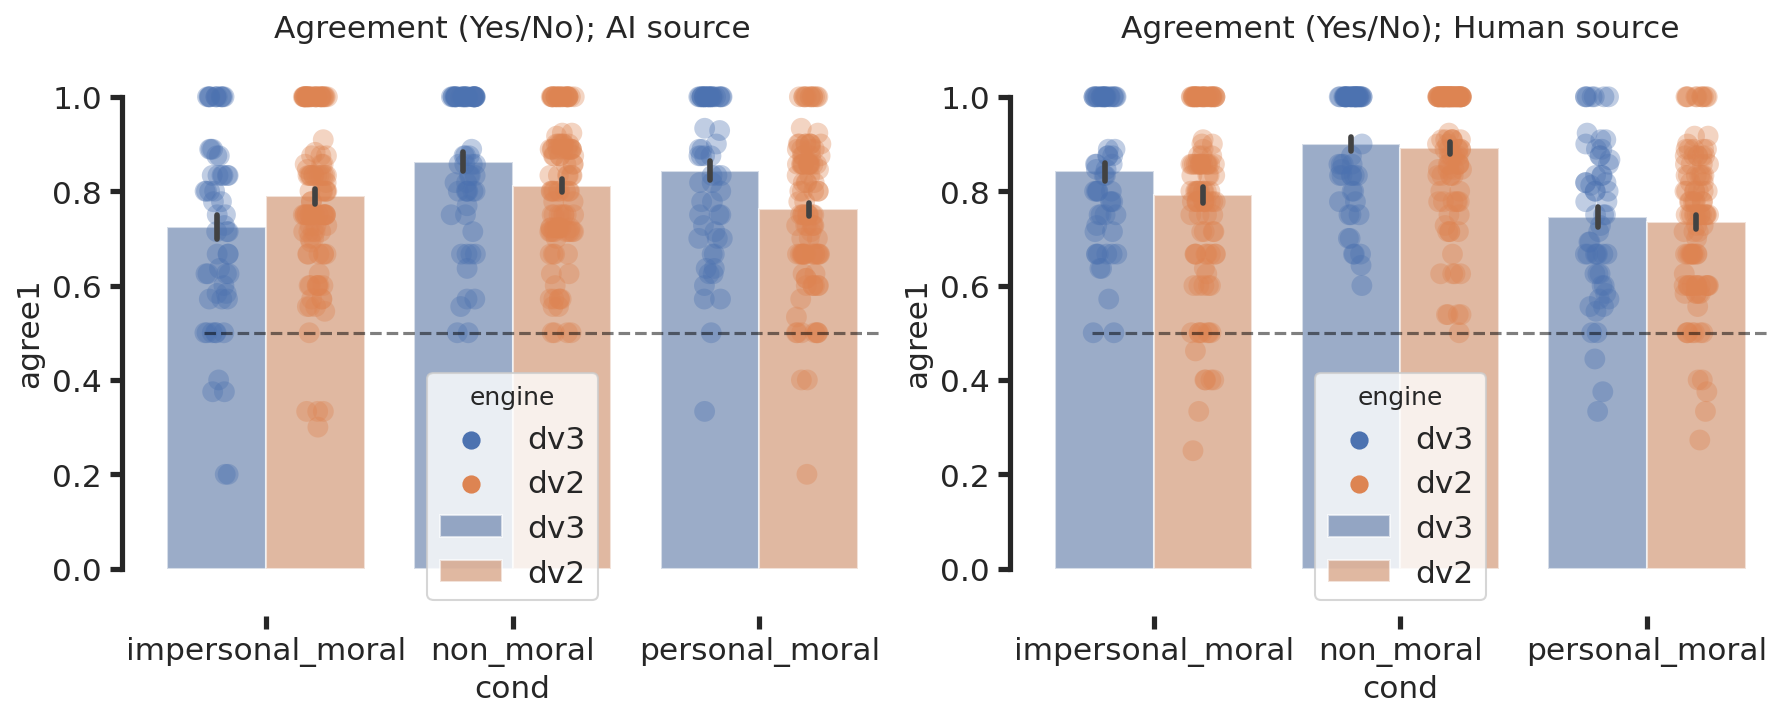

In [ ]:
sns.set(
    rc={'figure.figsize':(14,5), "figure.dpi": 150, 'legend.fontsize': 15, 'axes.labelsize': 15, 'axes.titlesize': 15,
      'xtick.labelsize': 15, 'ytick.labelsize': 15, 'font.family': 'sans-serif',
      'font.sans-serif': 'Arial', 'text.usetex': False})
# set S2 as default style
plt.rcParams['ytick.major.width'] = 2.5
plt.rcParams['xtick.major.width'] = 2.5


# sns.set_palette('Set2')
sns.set_palette('deep')
sns.set_style("ticks")

# -------------------------------------------------------------------------------
# Plot:  agreement 1 per correct and source + anova
# -------------------------------------------------------------------------------

avg = df[df.source=='AI'].groupby(['prolific_id', 'cond', 'engine'], as_index=False).mean()
plt.subplot(1, 2, 1)
# avg = df.groupby(['prolific_id', 'cond', 'agree1'], as_index=False).mean()
plt.plot([-0.25, 3.25], [0.5, 0.5], '--', color='black', alpha=0.5)
# raincloud(x='source', y='agree_both', markersize=12, df=avg, order=['AI', 'Human'])
sns.barplot(x='cond', y='agree1', hue='engine',data=avg, ci=68, alpha=0.6)
sns.stripplot(x='cond', y='agree1', data=avg, hue='engine', alpha=0.35, jitter=0.1, size=10, dodge=True, zorder=1)
plt.ylim(-.1, 1.1)
plt.title('Agreement (Yes/No); AI source')
# plt.xticks(range(2), ('', ''))
# plt.xlabel('')
# plt.xticks([])
# for i, c in enumerate(avg.source.unique()):
    # offset_image(i, c, plt.gca(), size=0.3)
sns.despine(offset=10, trim=True, bottom=True);
plt.gca().spines['left'].set_linewidth(2.5)
plt.gca().spines['bottom'].set_linewidth(2.5)
# plt.legend([], [], frameon=False)
print(pg.rm_anova(data=avg, dv='agree1', within='cond', subject='prolific_id', detailed=True))


#plt.plot([-0.25, 3.25], [0.5, 0.5], '--', color='black', alpha=0.5)
## raincloud(x='source', y='agree_both', markersize=12, df=avg, order=['AI', 'Human'])
#sns.barplot(x='cond', y='correct', data=avg, ci=68, alpha=0.6)
#sns.stripplot(x='cond', y='correct', data=avg, alpha=0.35, jitter=0.1, size=10, dodge=True, zorder=1)
#plt.ylim(-.1, 1.1)
#plt.title('Accuracy Turing')
#plt.xticks(range(2), ('', ''))
#plt.xlabel('')
#plt.xticks([])
## for i, c in enumerate(avg.source.unique()):
#    # offset_image(i, c, plt.gca(), size=0.3)
#sns.despine(offset=10, trim=True, bottom=True);
#plt.gca().spines['left'].set_linewidth(2.5)
#plt.gca().spines['bottom'].set_linewidth(2.5)
#plt.legend([], [], frameon=False)
#print(pg.rm_anova(data=avg, dv='correct', within='cond', subject='prolific_id', detailed=True))


# -------------------------------------------------------------------------------
# Plot:  agreement 2 per correct and source + anova
# -------------------------------------------------------------------------------
#
avg = df[df.source=='Human'].groupby(['prolific_id', 'cond', 'engine'], as_index=False).mean()
plt.subplot(1, 2, 2)
# avg = df.groupby(['prolific_id', 'cond', 'agree1'], as_index=False).mean()
plt.plot([-0.25, 3.25], [0.5, 0.5], '--', color='black', alpha=0.5)
# raincloud(x='source', y='agree_both', markersize=12, df=avg, order=['AI', 'Human'])
sns.barplot(x='cond', y='agree1', hue='engine',data=avg, ci=68, alpha=0.6)
sns.stripplot(x='cond', y='agree1', data=avg, hue='engine', alpha=0.35, jitter=0.1, size=10, dodge=True, zorder=1)
plt.ylim(-.1, 1.1)
plt.title('Agreement (Yes/No); Human source')
# plt.xticks(range(2), ('', ''))
# plt.xlabel('')
# plt.xticks([])
# for i, c in enumerate(avg.source.unique()):
    # offset_image(i, c, plt.gca(), size=0.3)
sns.despine(offset=10, trim=True, bottom=True);
plt.gca().spines['left'].set_linewidth(2.5)
plt.gca().spines['bottom'].set_linewidth(2.5)
# plt.legend([], [], frameon=False)
print(pg.rm_anova(data=avg, dv='agree1', within='cond', subject='prolific_id', detailed=True))
